In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import exploring_script as es
import importlib
importlib.reload(es)
import pandas as pd
import swifter
import numpy as np
from fink_utils.photometry.vect_conversion import vect_dc_mag

In [4]:
from swifter import set_defaults
set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=True,
)

In [5]:
confirmed_sso = es.load_data(columns=["ssnamenr", "fid", 'magpsf', 'sigmapsf', 'magnr', 'sigmagnr', 'magzpsci', 'isdiffpos', "jd", "nid"])

In [5]:
confirmed_sso["dcmag"], confirmed_sso["sigdcmag"] = vect_dc_mag(
    confirmed_sso["fid"],
    confirmed_sso["magpsf"],
    confirmed_sso["sigmapsf"],
    confirmed_sso["magnr"],
    confirmed_sso["sigmagnr"],
    confirmed_sso["magzpsci"],
    confirmed_sso["isdiffpos"]
)

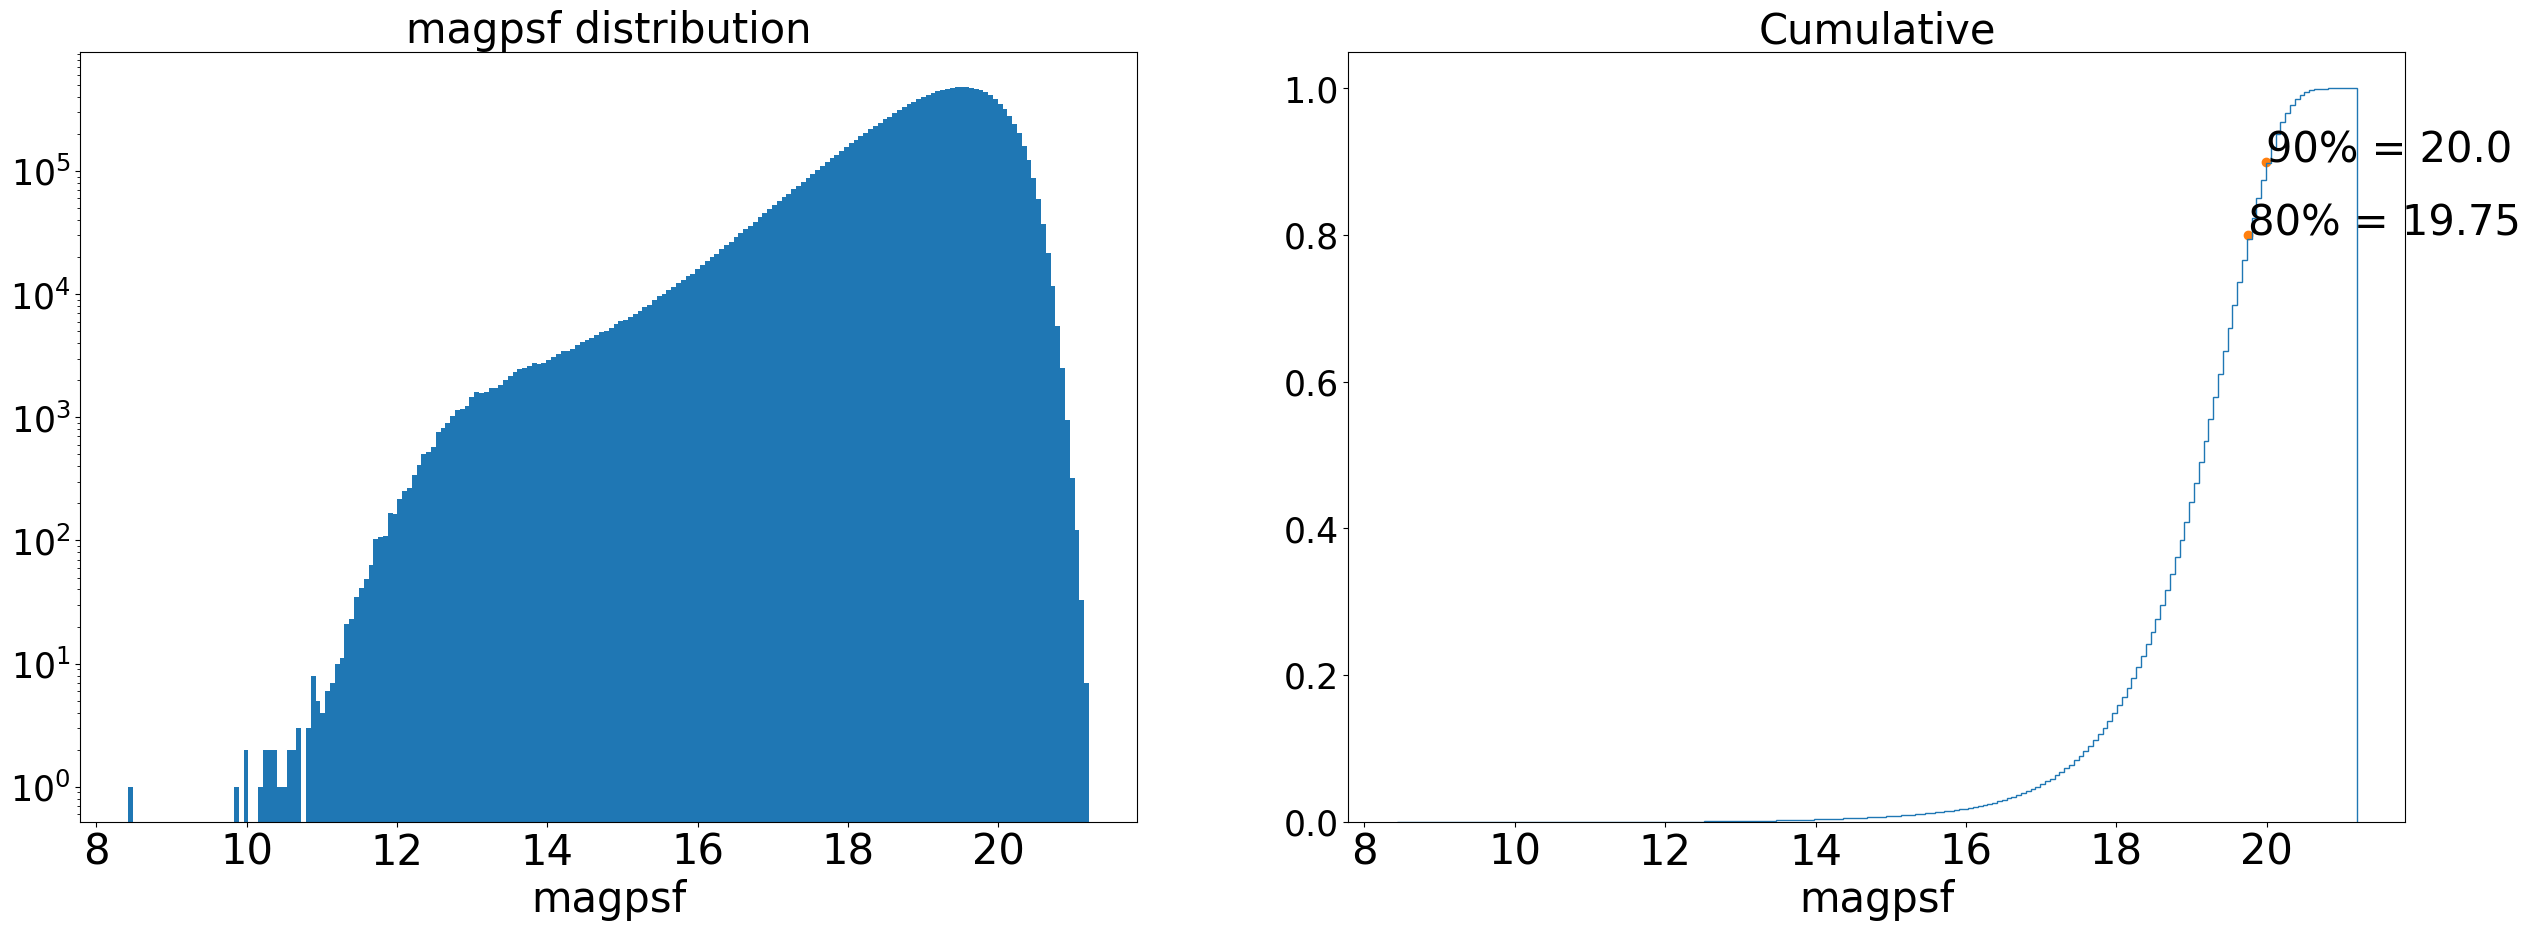

In [6]:
es.plot_hist_and_cdf(confirmed_sso["magpsf"], None, "magpsf distribution", "magpsf", "", None, "Cumulative", "magpsf", "")

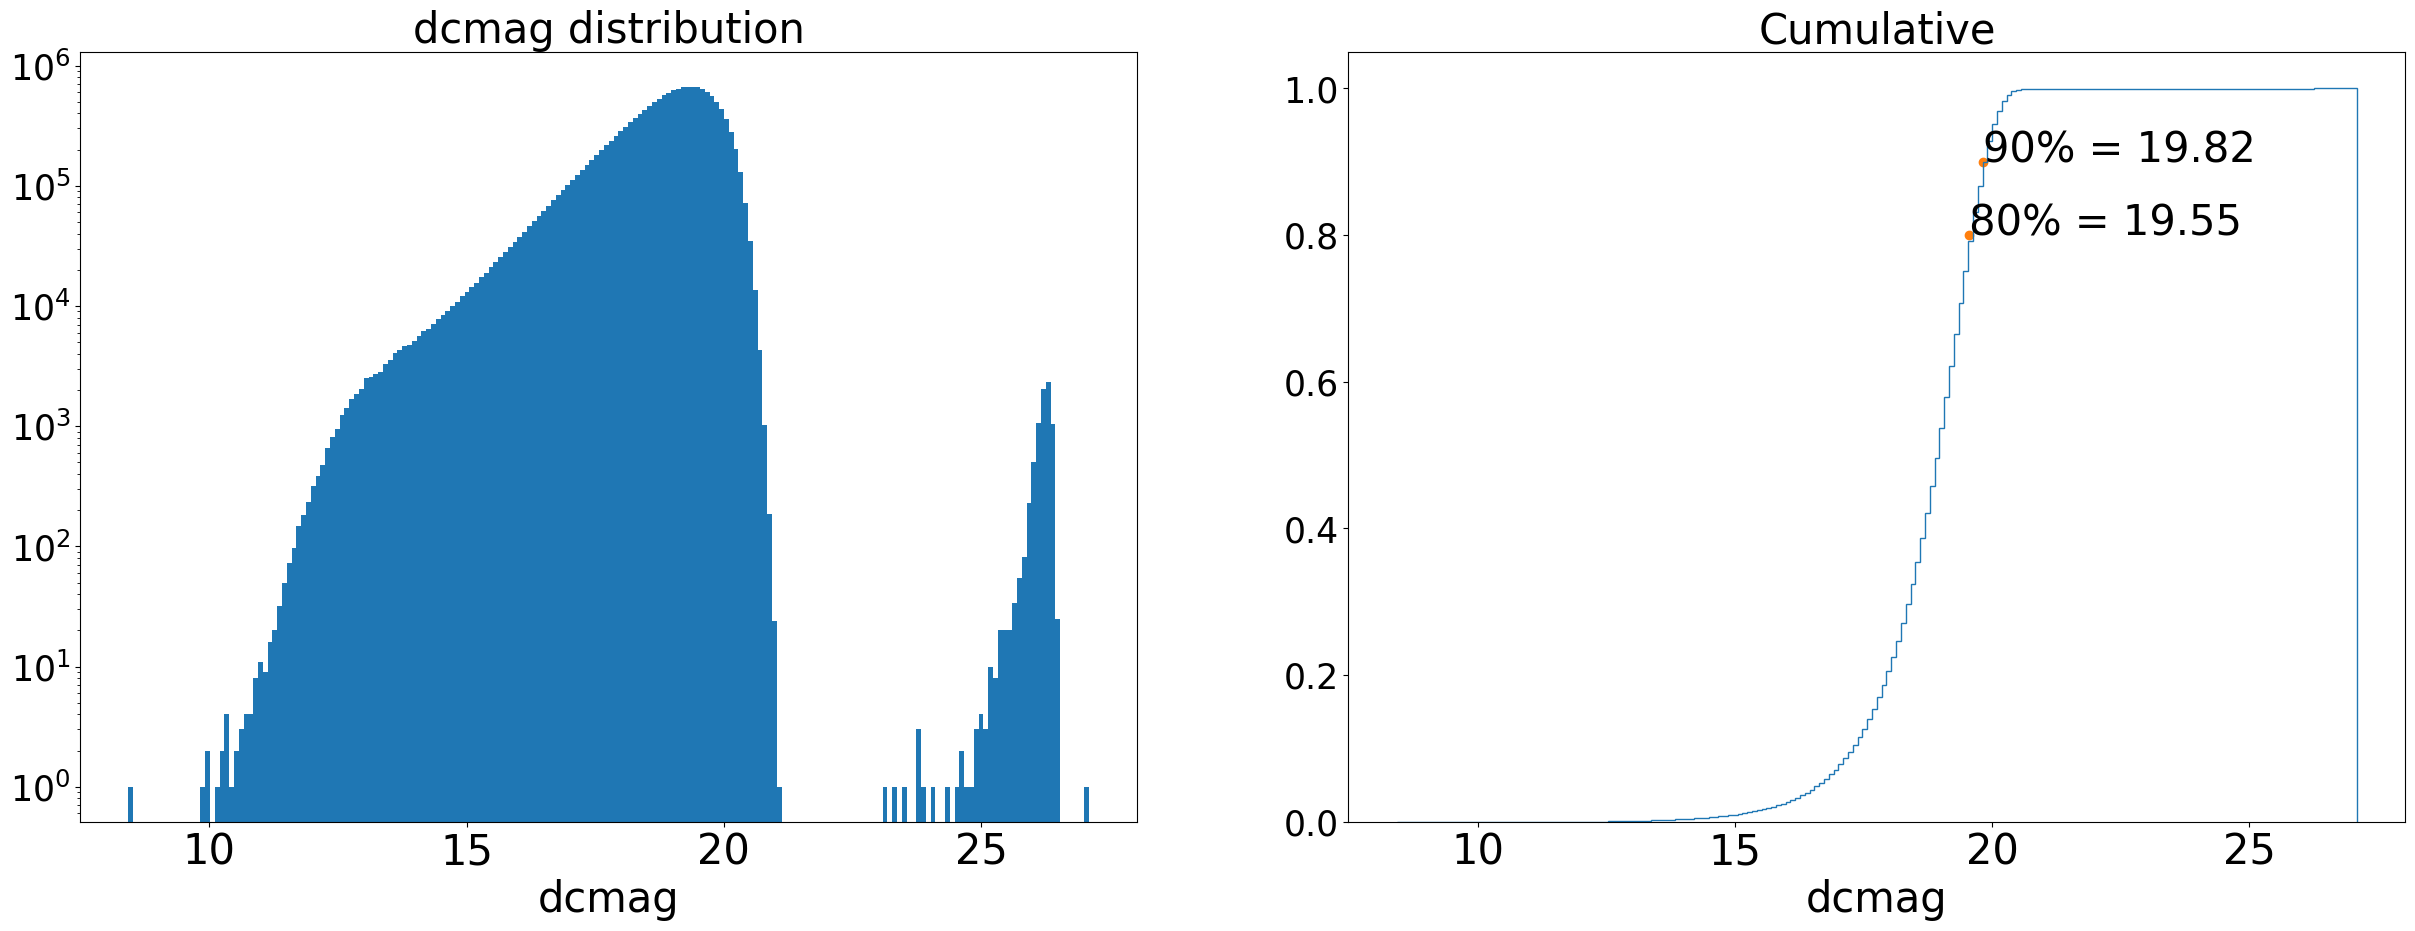

In [7]:
es.plot_hist_and_cdf(confirmed_sso["dcmag"], None, "dcmag distribution", "dcmag", "", None, "Cumulative", "dcmag", "")

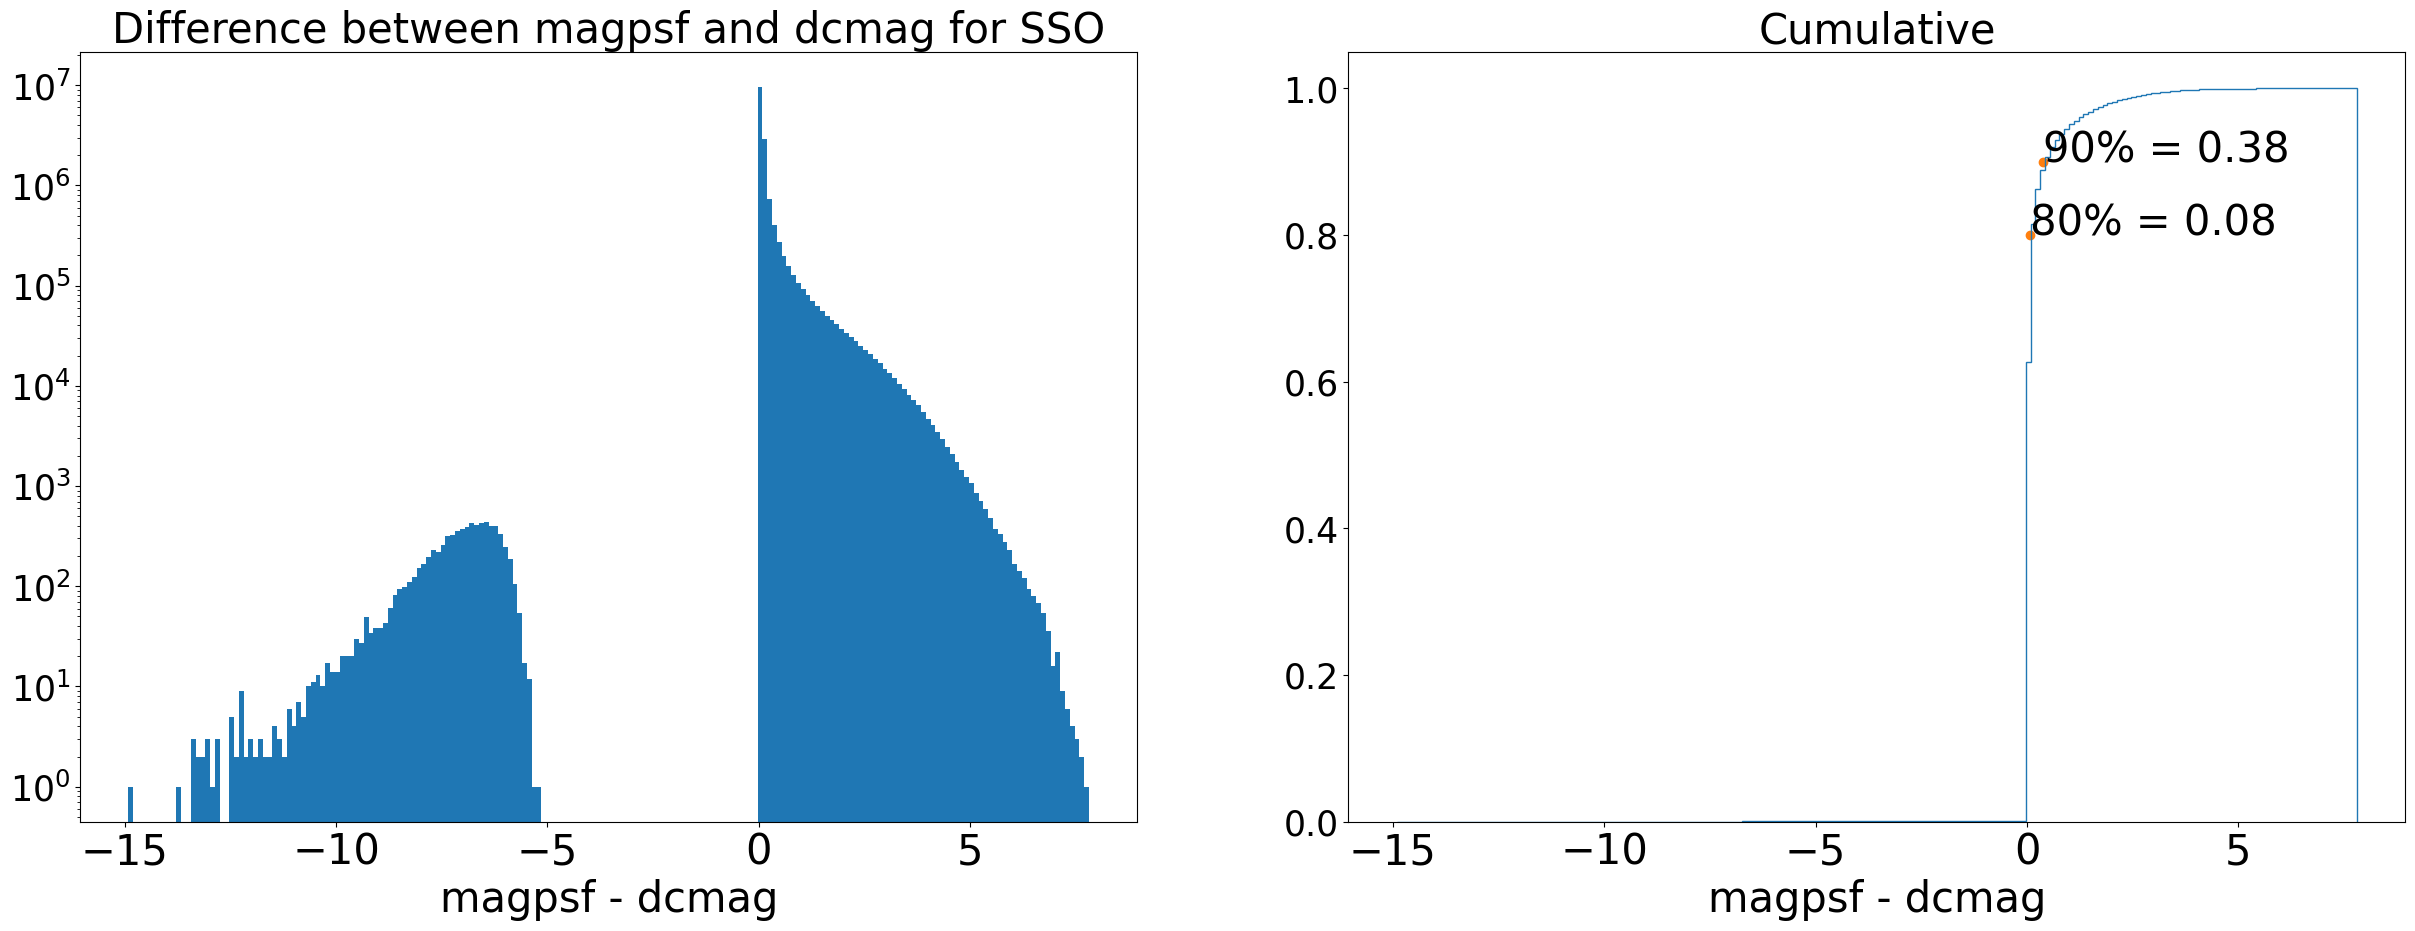

In [8]:
es.plot_hist_and_cdf((confirmed_sso["magpsf"] - confirmed_sso["dcmag"]), None, "Difference between magpsf and dcmag for SSO", "magpsf - dcmag", "", None, "Cumulative", "magpsf - dcmag", "")

In [6]:
prep_rate_gb = confirmed_sso.sort_values("jd").groupby("ssnamenr").agg(list)

In [18]:
rate_and_color = prep_rate_gb.swifter.apply(es.mag_df, axis=1)

Pandas Apply:   0%|          | 0/517611 [00:00<?, ?it/s]

In [19]:
rate_g = rate_and_color.explode().reset_index(drop=True)[::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
rate_r = rate_and_color.explode().reset_index(drop=True)[1::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
color = rate_and_color.explode().reset_index(drop=True)[2::3].explode().reset_index(drop=True)
color = color[color != 0]

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


### Magnitude study (all alerts)

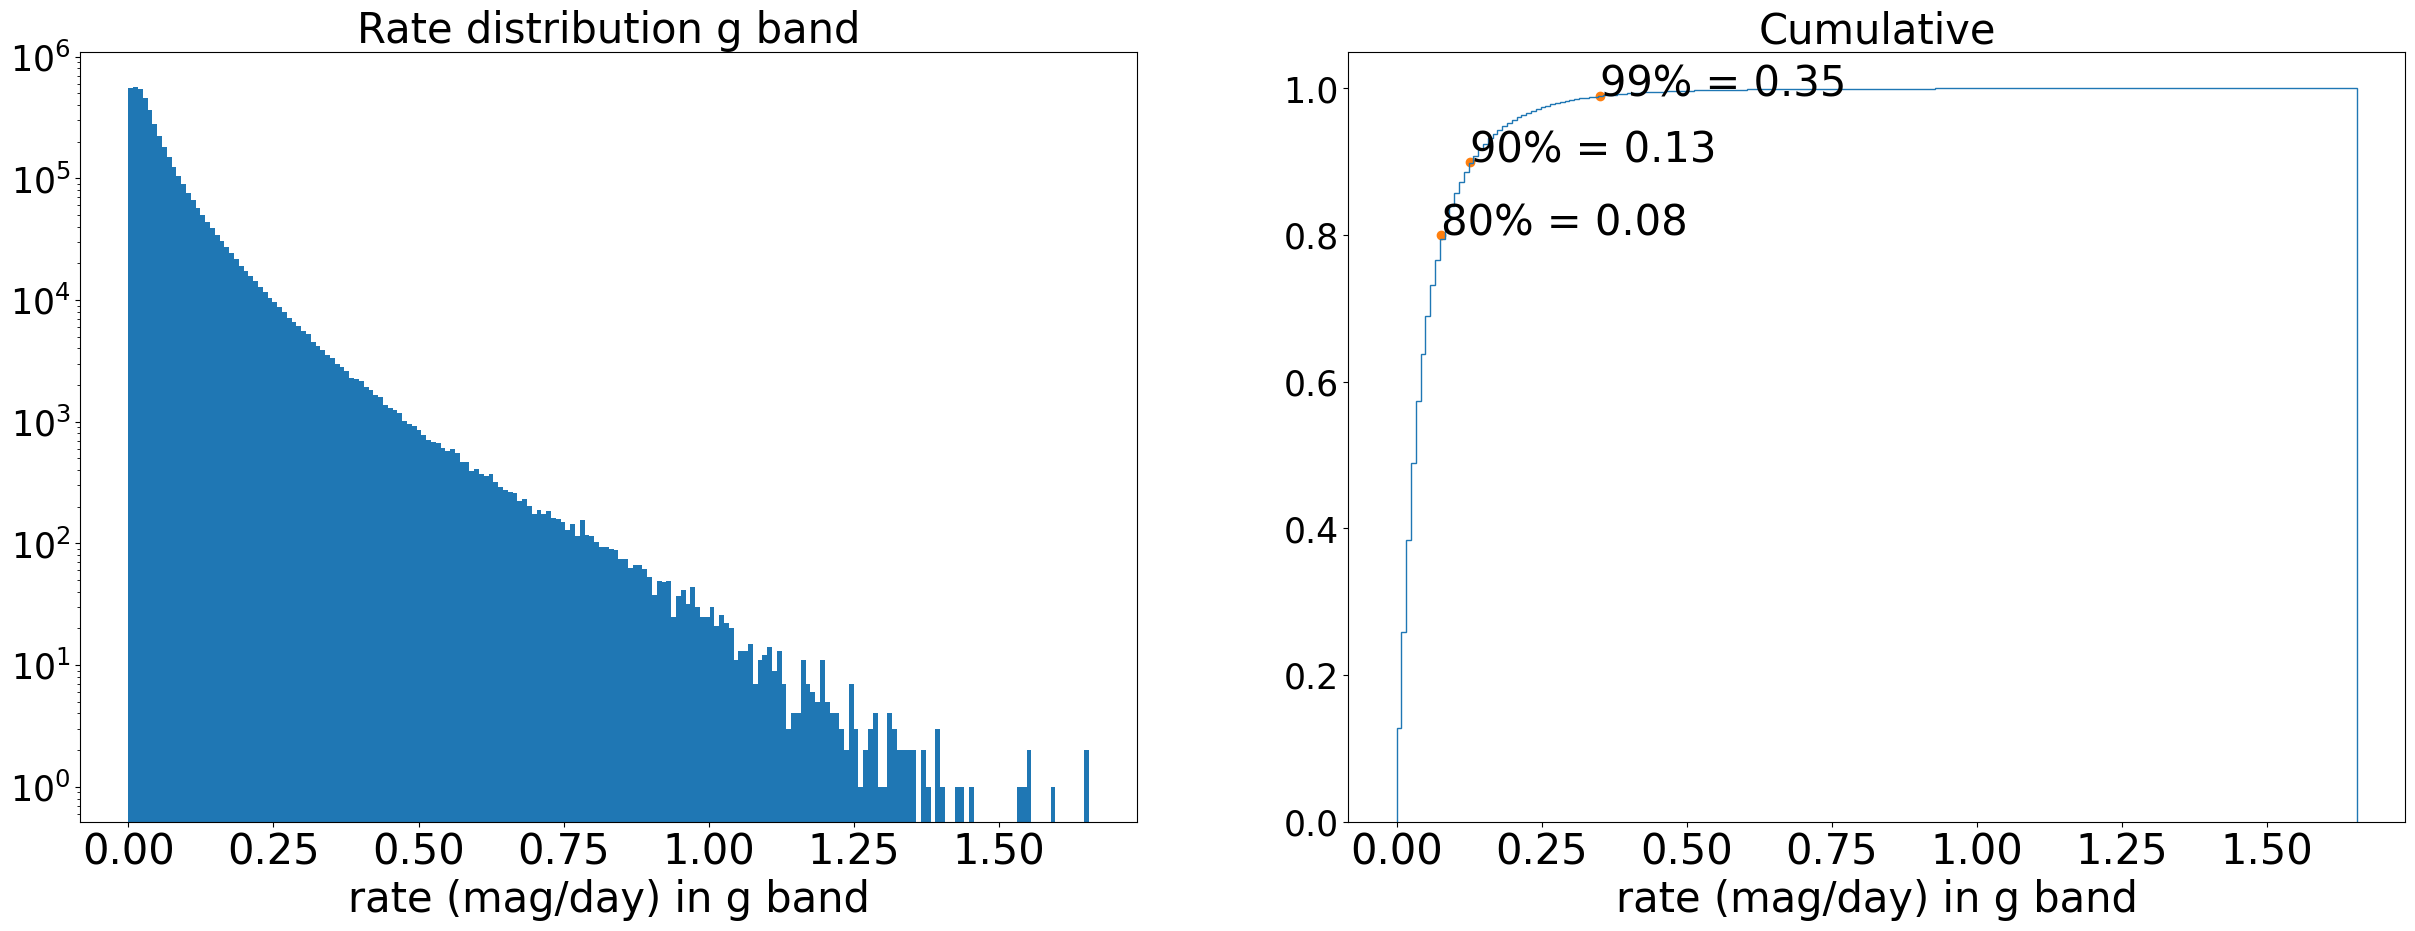

In [20]:
es.plot_hist_and_cdf(rate_g, None, "Rate distribution g band", "rate (mag/day) in g band", "", None, "Cumulative", "rate (mag/day) in g band", "", percent_cdf=[0.8, 0.9, 0.99])

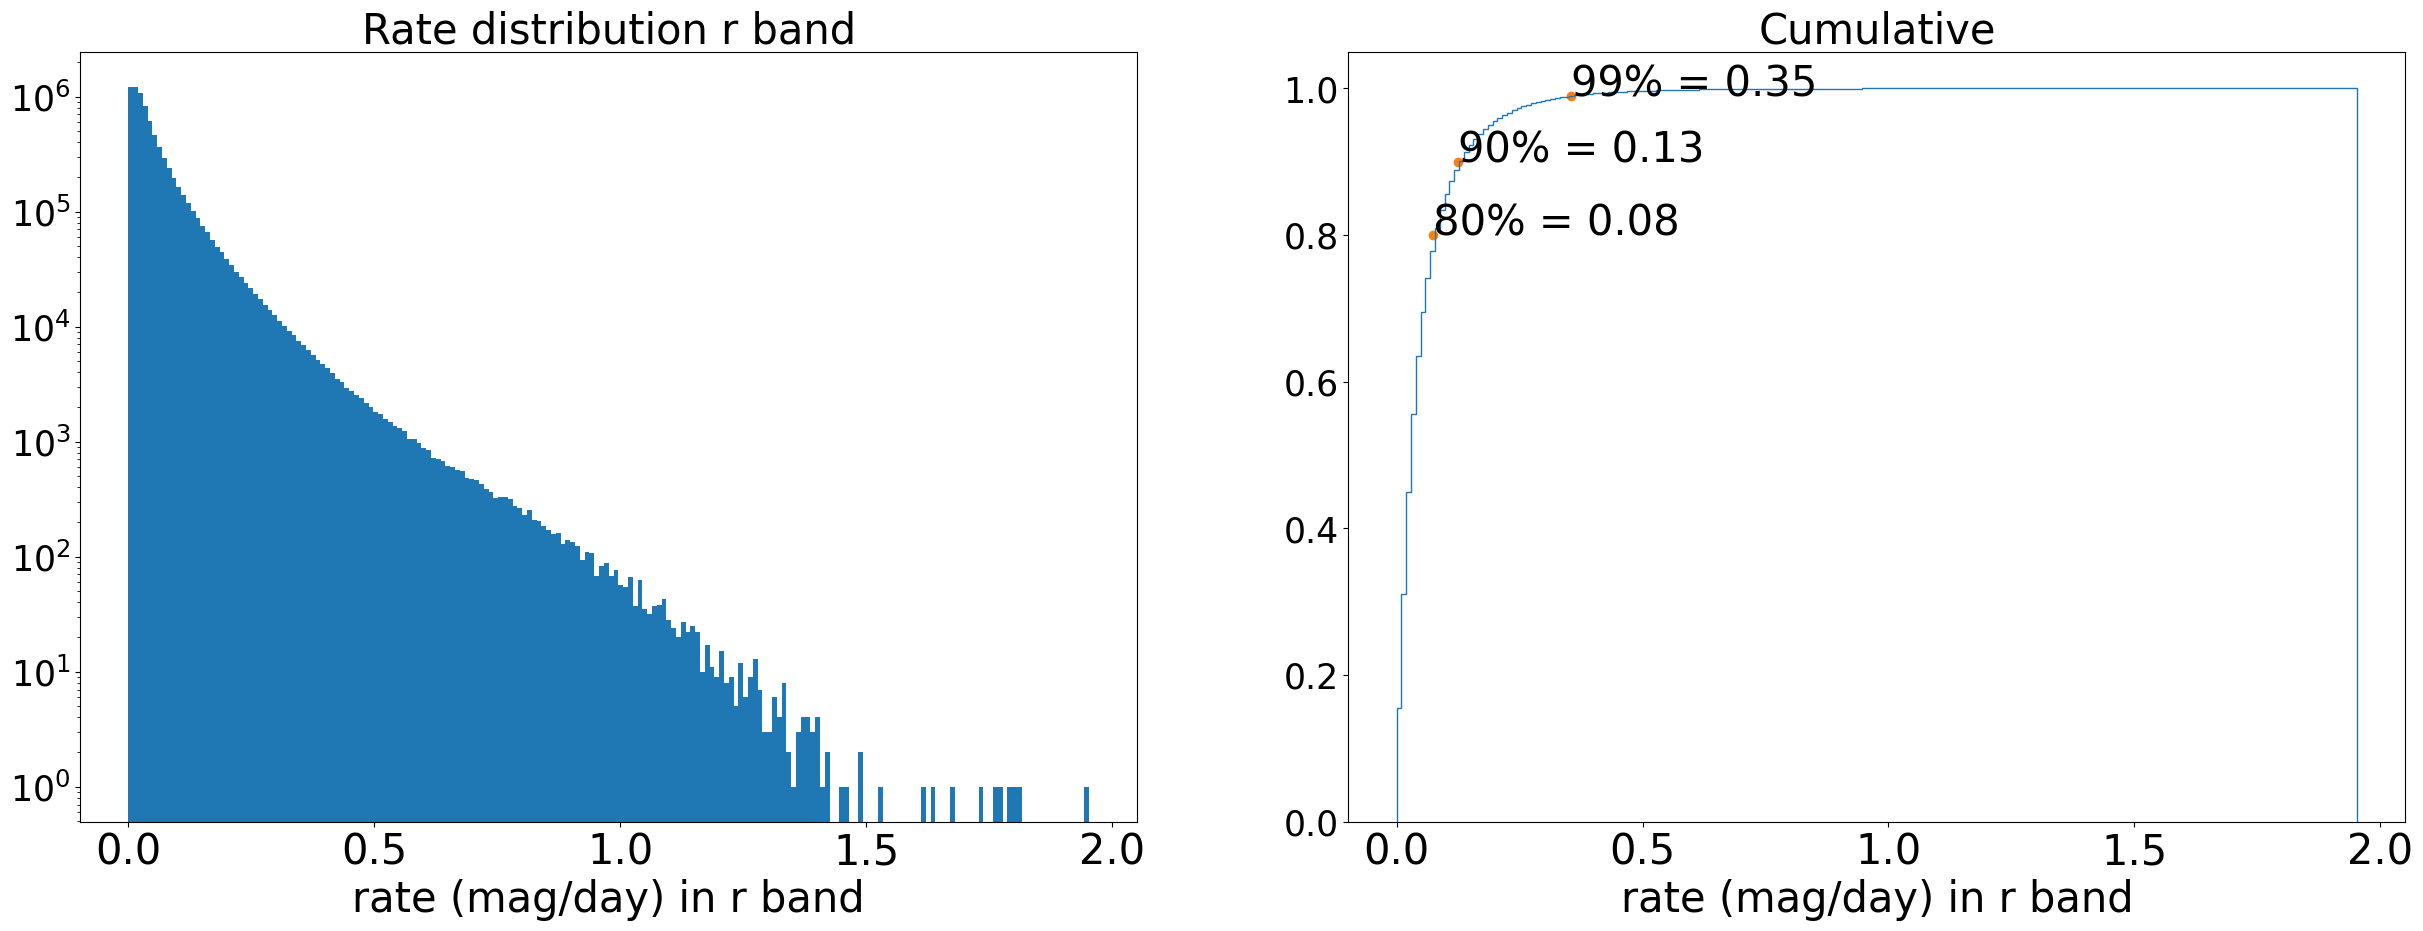

In [21]:
es.plot_hist_and_cdf(rate_r, None, "Rate distribution r band", "rate (mag/day) in r band", "", None, "Cumulative", "rate (mag/day) in r band", "", percent_cdf=[0.8, 0.9, 0.99])

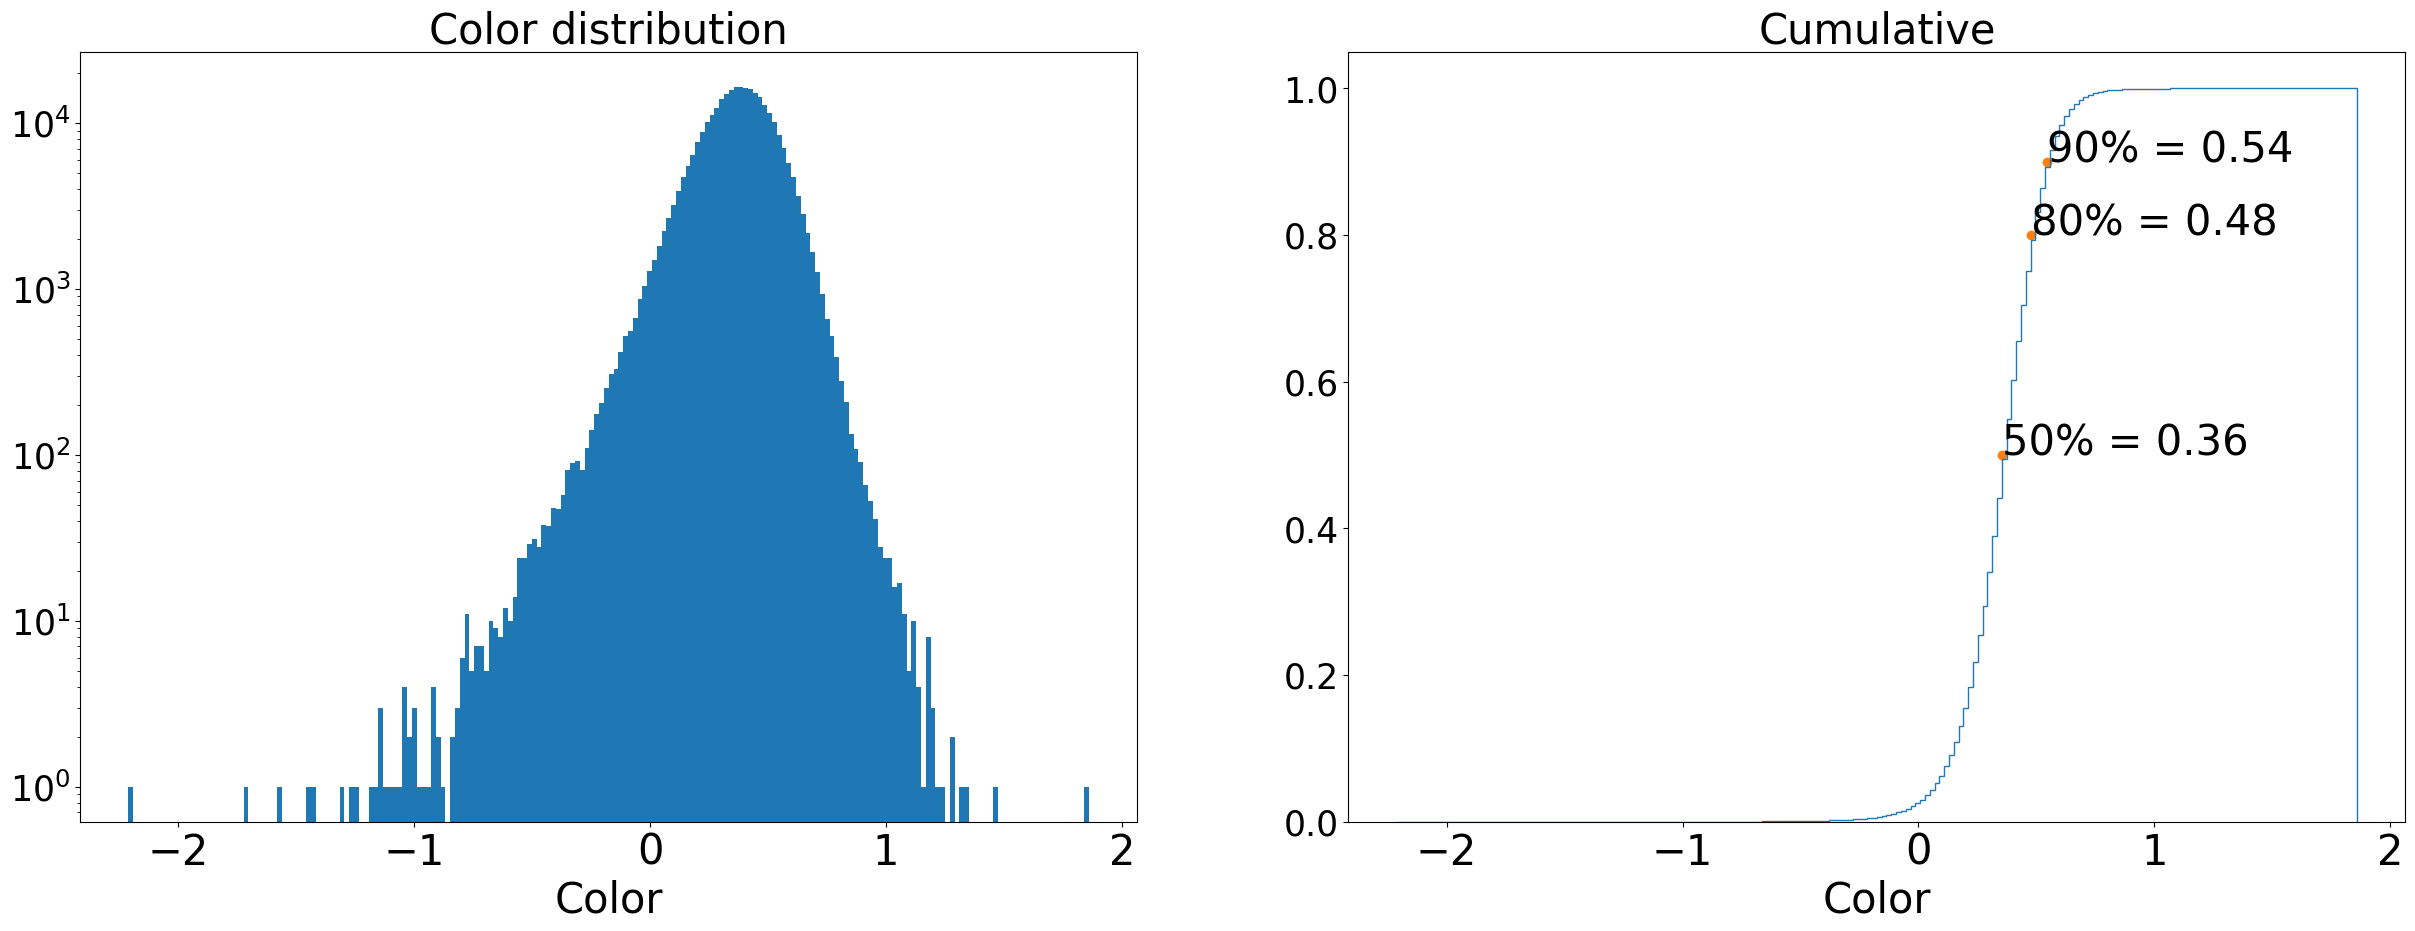

In [14]:
es.plot_hist_and_cdf(color, None, "Color distribution", "Color", "", None, "Cumulative", "Color", "", percent_cdf=[0.5, 0.8, 0.9])

### Magnitude study (intra night alerts)

In [20]:
prep_intra_rate_gb = confirmed_sso[["ssnamenr", "nid", "jd", "magpsf", "fid"]].sort_values("jd").groupby(["nid", "ssnamenr"]).agg(
    jd=("jd", list),
    magpsf=("magpsf", list),
    fid=("fid", list),
    nb_obs=("magpsf", len)
)

In [22]:
prep_intra_rate = prep_intra_rate_gb[prep_intra_rate_gb["nb_obs"] > 1]

In [24]:
intra_rate_and_color = prep_intra_rate.reset_index(drop=True).swifter.apply(es.mag_df, axis=1)

Pandas Apply:   0%|          | 0/4136628 [00:00<?, ?it/s]

In [25]:
intra_rate_g = intra_rate_and_color.explode().reset_index(drop=True)[::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
intra_rate_r = intra_rate_and_color.explode().reset_index(drop=True)[1::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
intra_color = intra_rate_and_color.explode().reset_index(drop=True)[2::3].explode().reset_index(drop=True)
intra_color = intra_color[intra_color != 0]

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


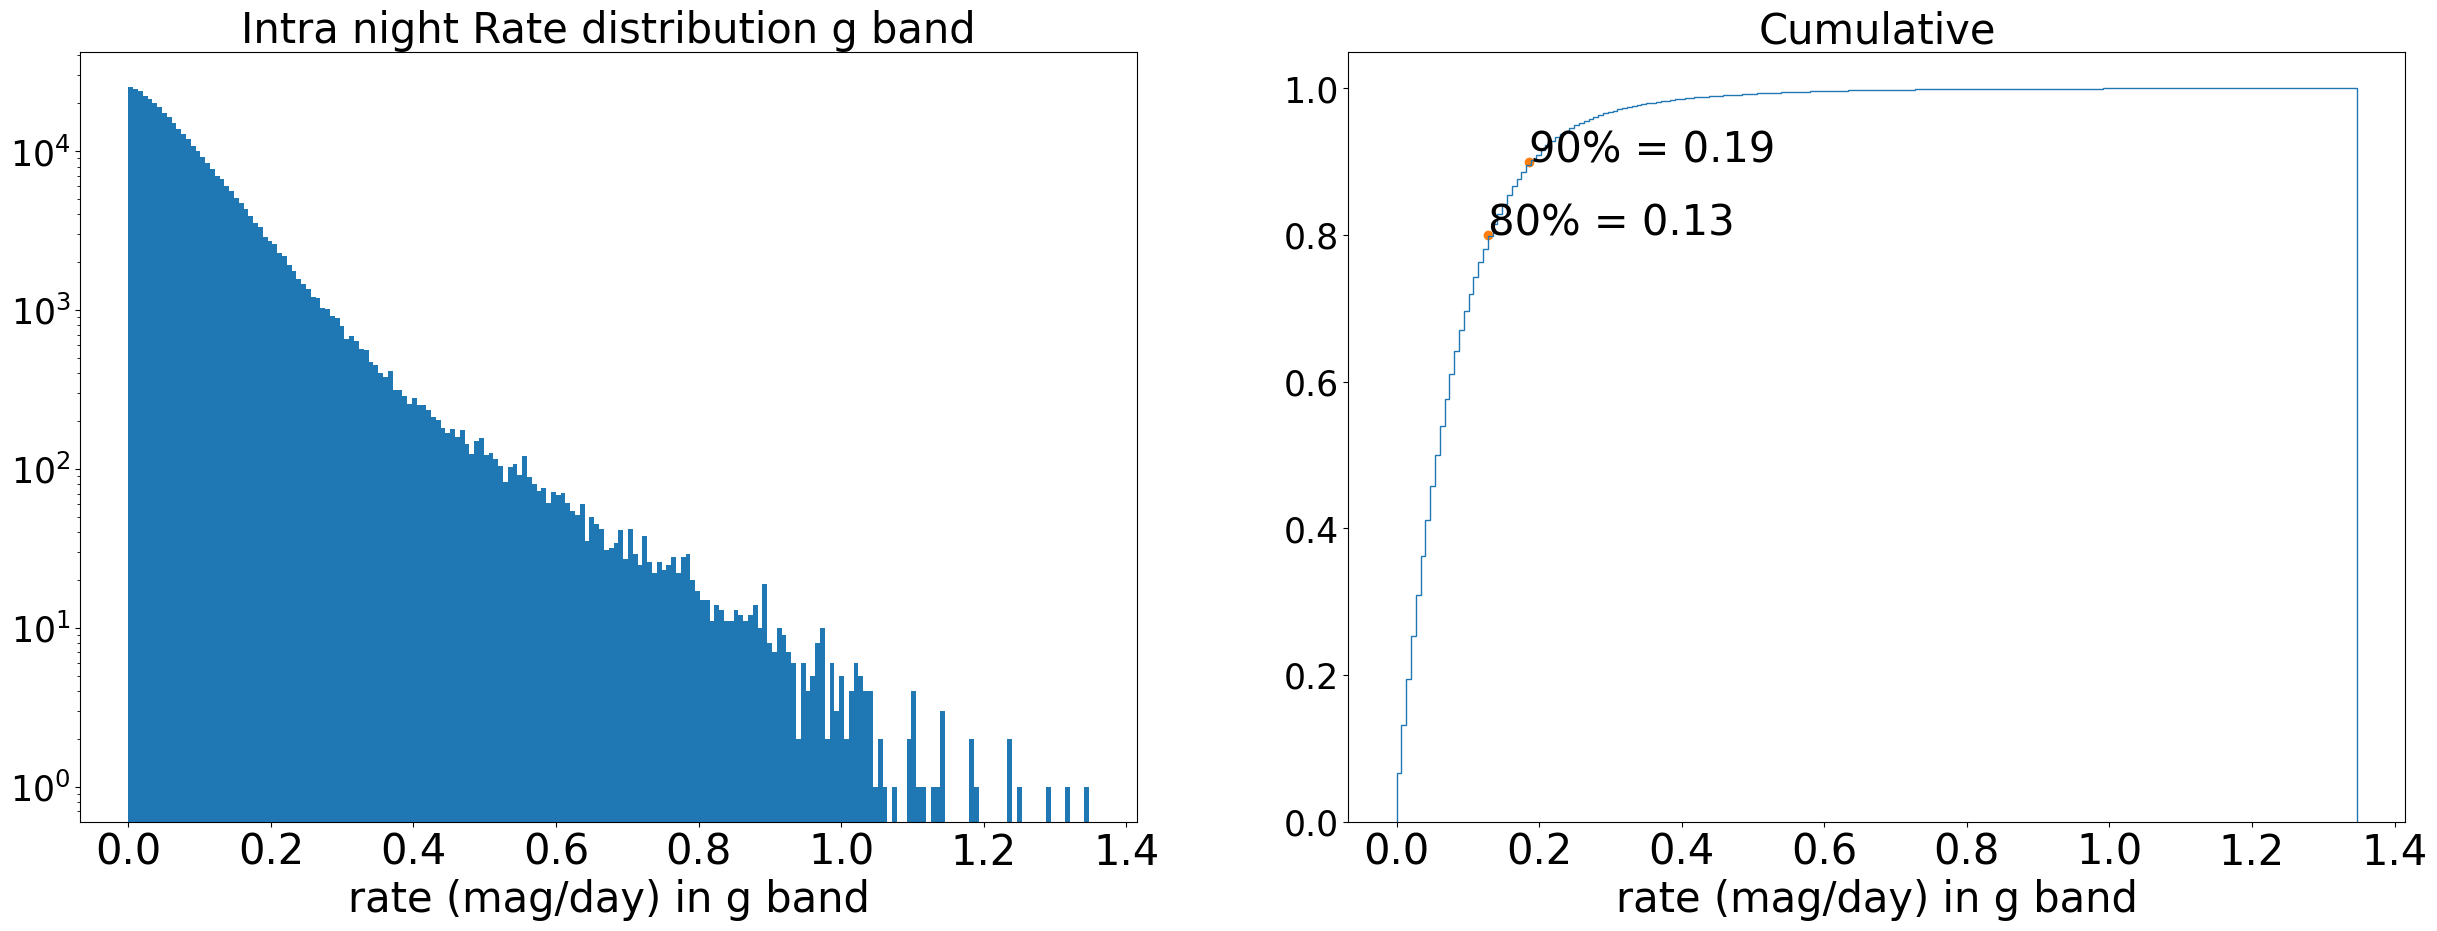

In [29]:
es.plot_hist_and_cdf(intra_rate_g, None, "Intra night Rate distribution g band", "rate (mag/day) in g band", "", None, "Cumulative", "rate (mag/day) in g band", "")

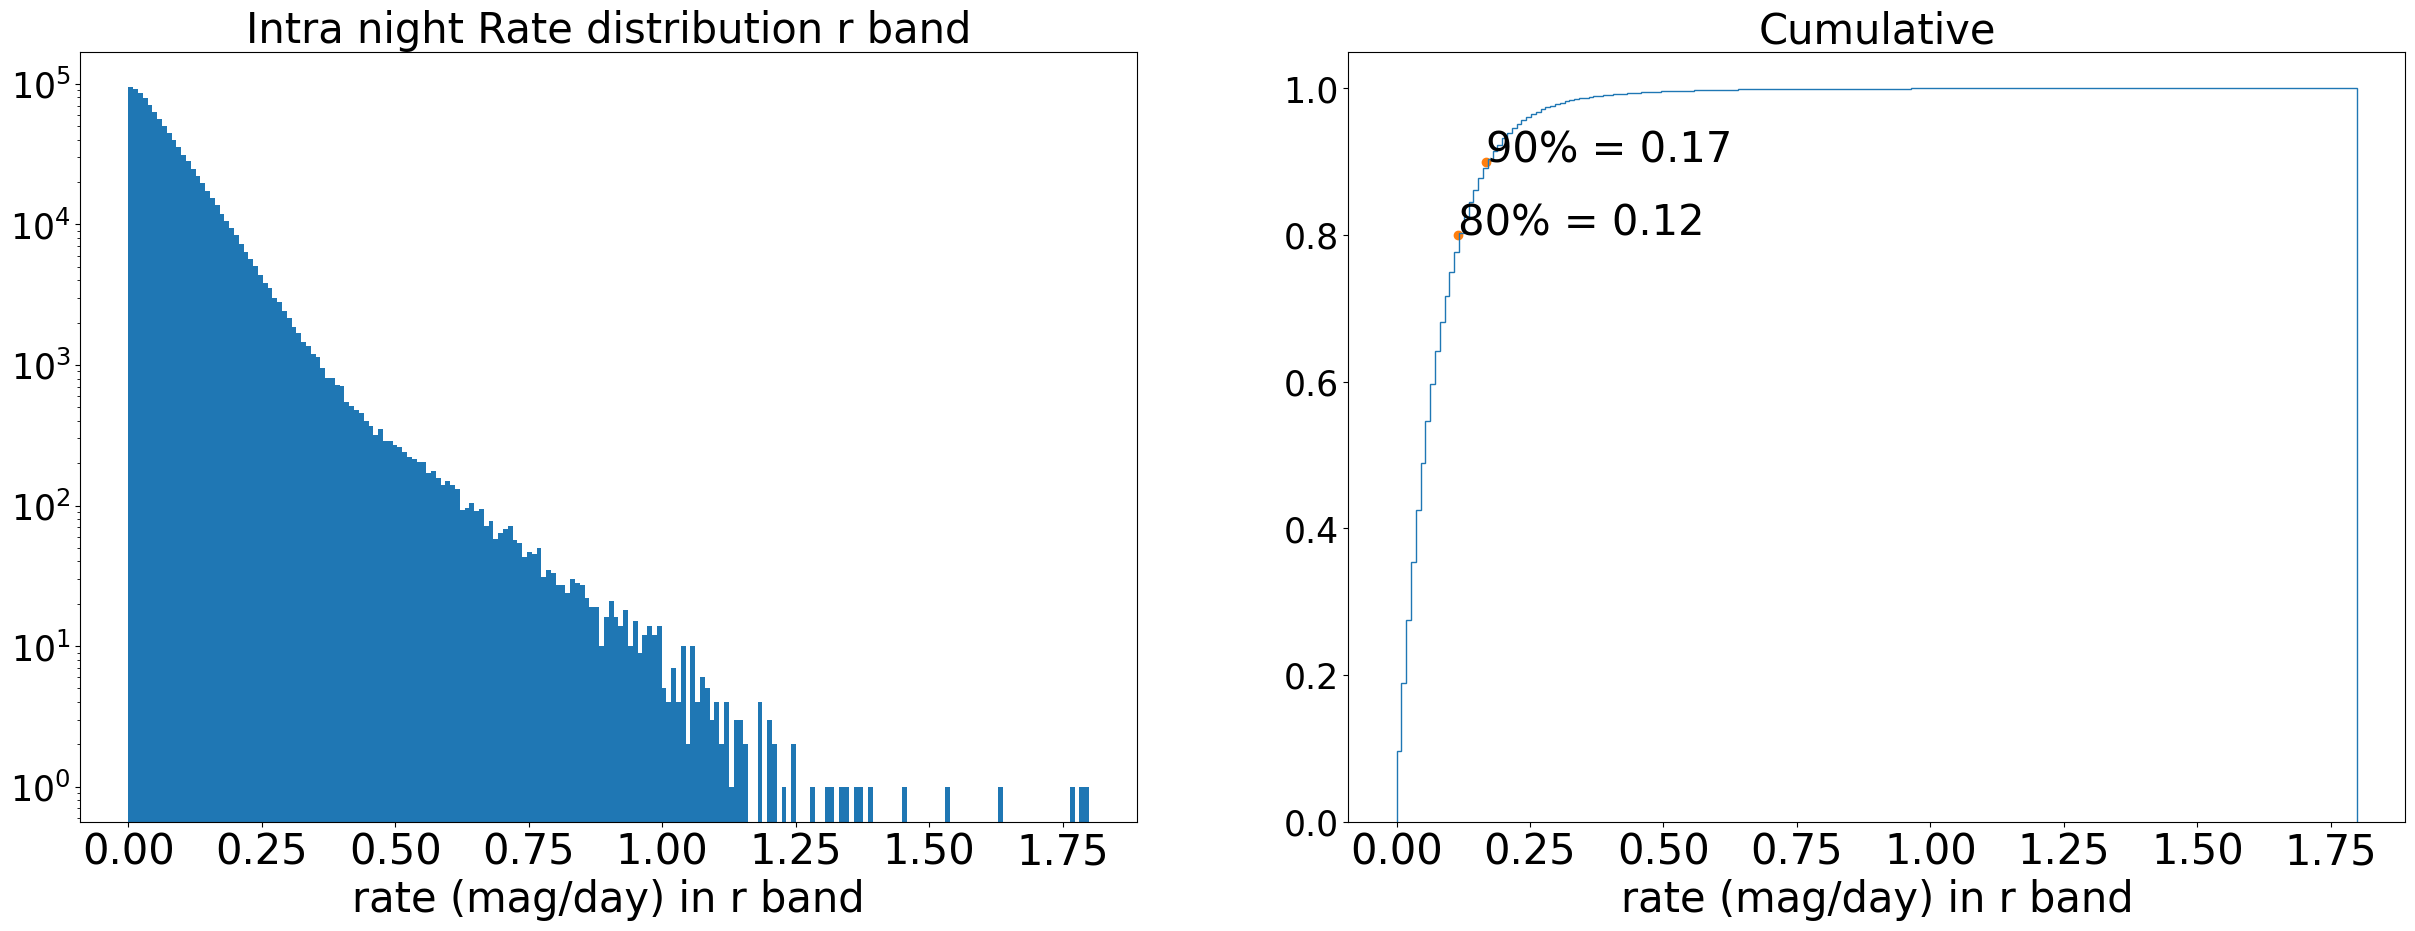

In [30]:
es.plot_hist_and_cdf(intra_rate_r, None, "Intra night Rate distribution r band", "rate (mag/day) in r band", "", None, "Cumulative", "rate (mag/day) in r band", "")

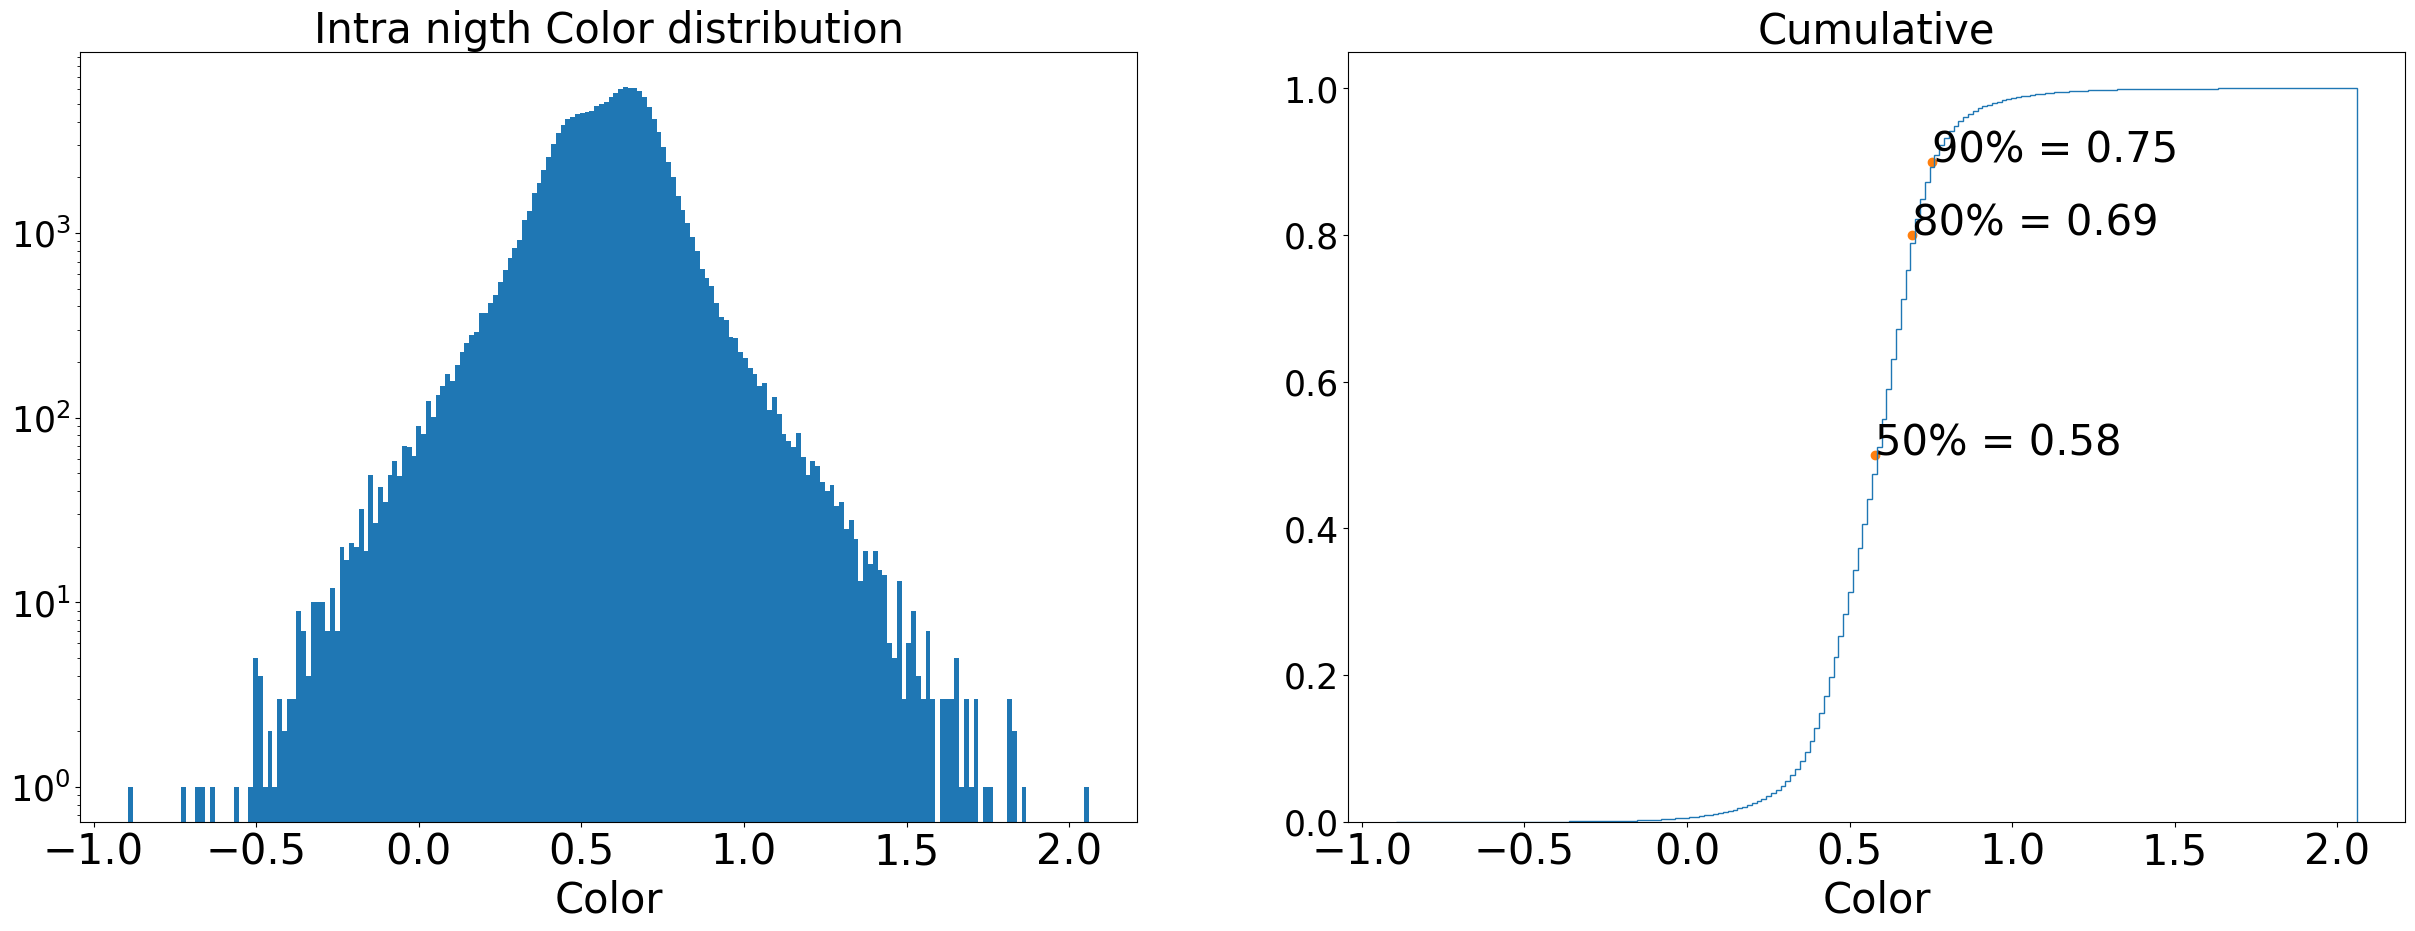

: 

In [31]:
es.plot_hist_and_cdf(intra_color, None, "Intra nigth Color distribution", "Color", "", None, "Cumulative", "Color", "", percent_cdf=[0.5, 0.8, 0.9])

### NEA Magnitude

In [7]:
nea_class = ["NEA>Amor", "NEA>Apollo", "NEA>Aten", "NEA>Atira"]

In [8]:
rocks_fink = pd.read_parquet("data/rocks_fink.parquet")
bft_sso = pd.read_parquet(
    "../data/BFT_Miriade/ssoBFT-latest.parquet",
    columns=[
        "sso_name", "sso_class", 
        "orbital_elements.inclination.value",
        "orbital_elements.semi_major_axis.value",
        "orbital_elements.eccentricity.value"
        ]
)

In [9]:
merge_bft_fink = bft_sso.merge(rocks_fink, left_on="sso_name", right_on="ast_name")
merge_bft_fink["ast_number"] = np.nan_to_num(merge_bft_fink["ast_number"], nan=-1.0).astype(int).astype("str")
bft_nea = merge_bft_fink[merge_bft_fink["sso_class"].isin(nea_class)]
nea_fink = bft_nea.merge(confirmed_sso, left_on="ast_number", right_on="ssnamenr")

In [11]:
prep_rate_gb = nea_fink.sort_values("jd").groupby("ssnamenr").agg(list)
rate_and_color = prep_rate_gb.swifter.apply(es.mag_df, axis=1)

rate_g = rate_and_color.explode().reset_index(drop=True)[::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
rate_r = rate_and_color.explode().reset_index(drop=True)[1::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
color = rate_and_color.explode().reset_index(drop=True)[2::3].explode().reset_index(drop=True)
color = color[color != 0]

Pandas Apply:   0%|          | 0/1427 [00:00<?, ?it/s]

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


#### Magnitude NEA (Intra + Inter)

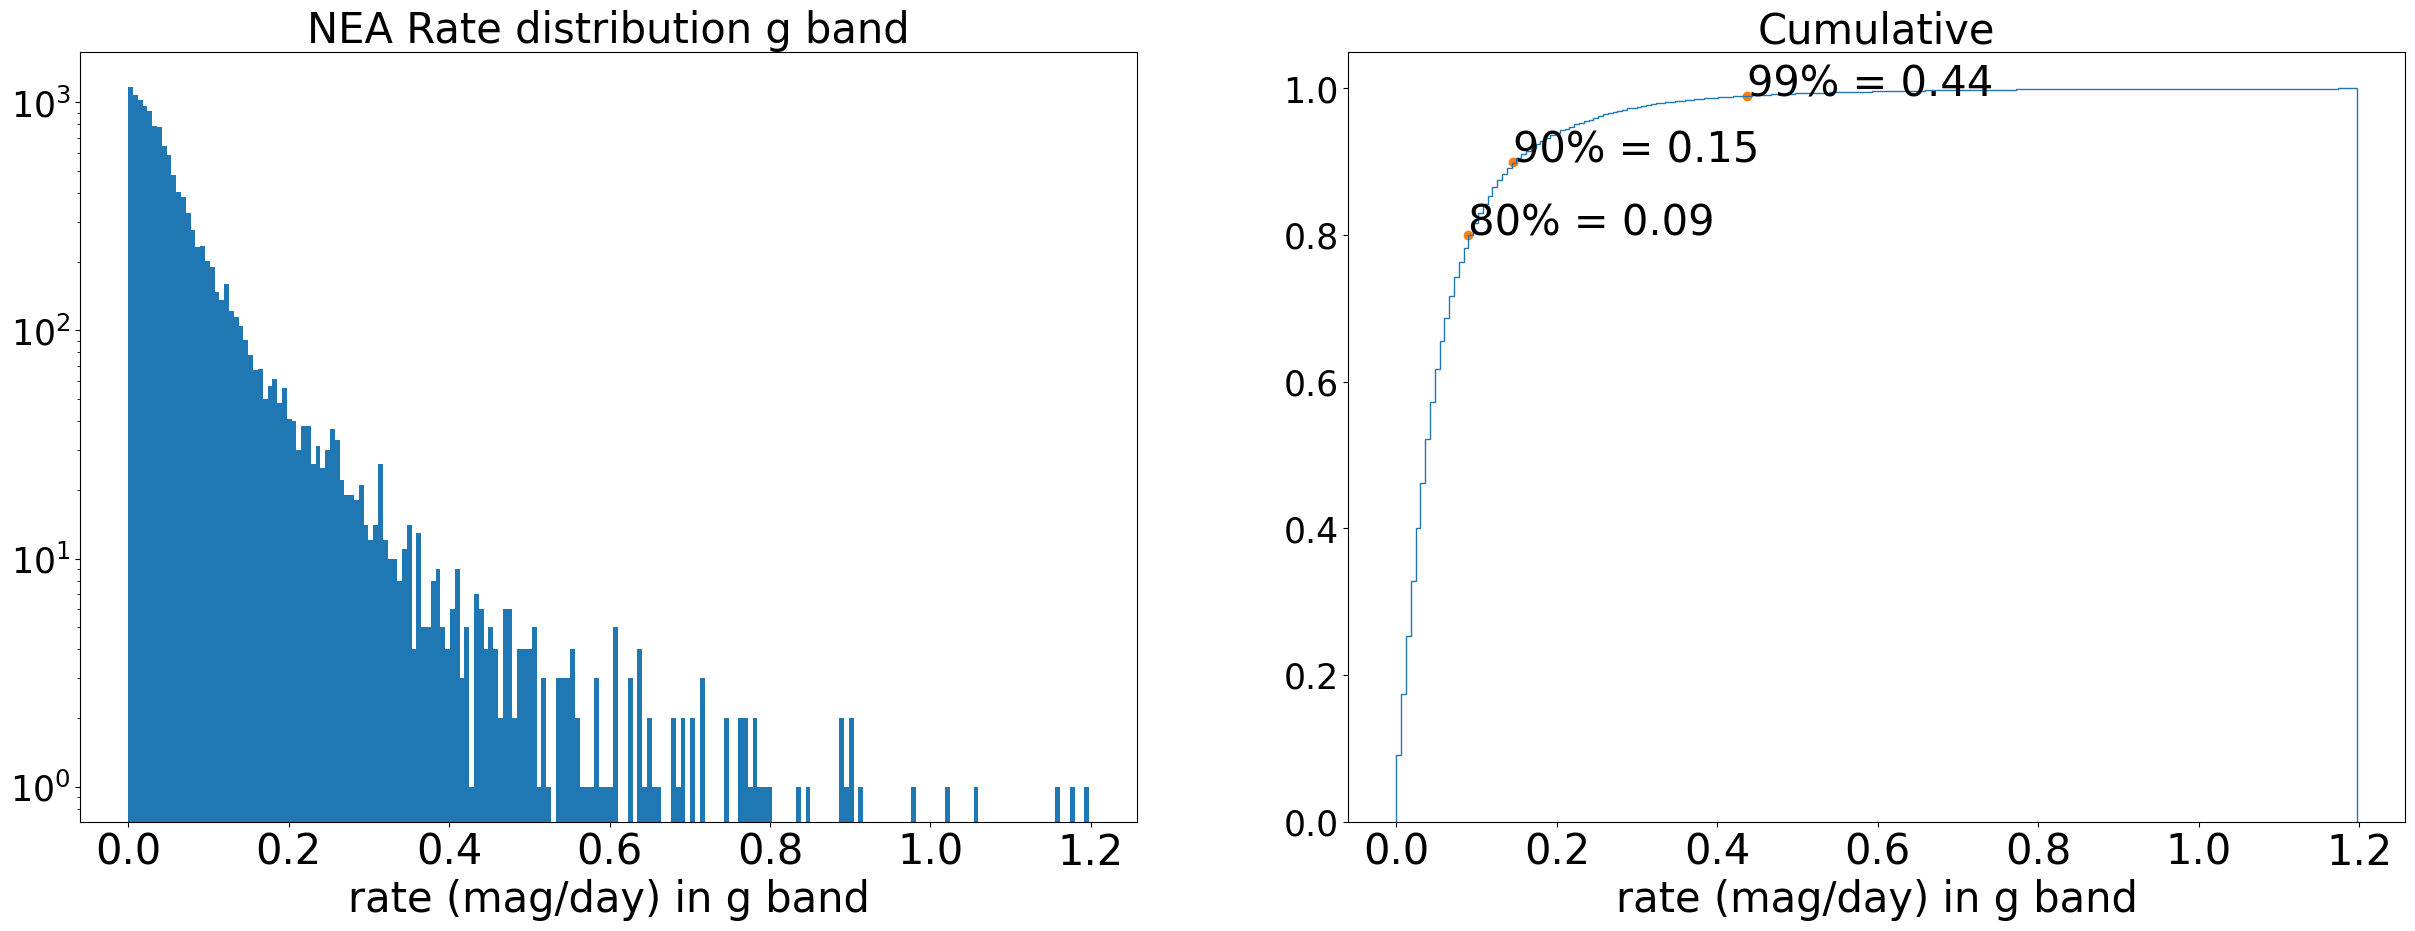

In [14]:
es.plot_hist_and_cdf(
    rate_g, 
    None, 
    "NEA Rate distribution g band", 
    "rate (mag/day) in g band", 
    "", 
    None, 
    "Cumulative", 
    "rate (mag/day) in g band", 
    "", 
    percent_cdf=[0.8, 0.9, 0.99]
)

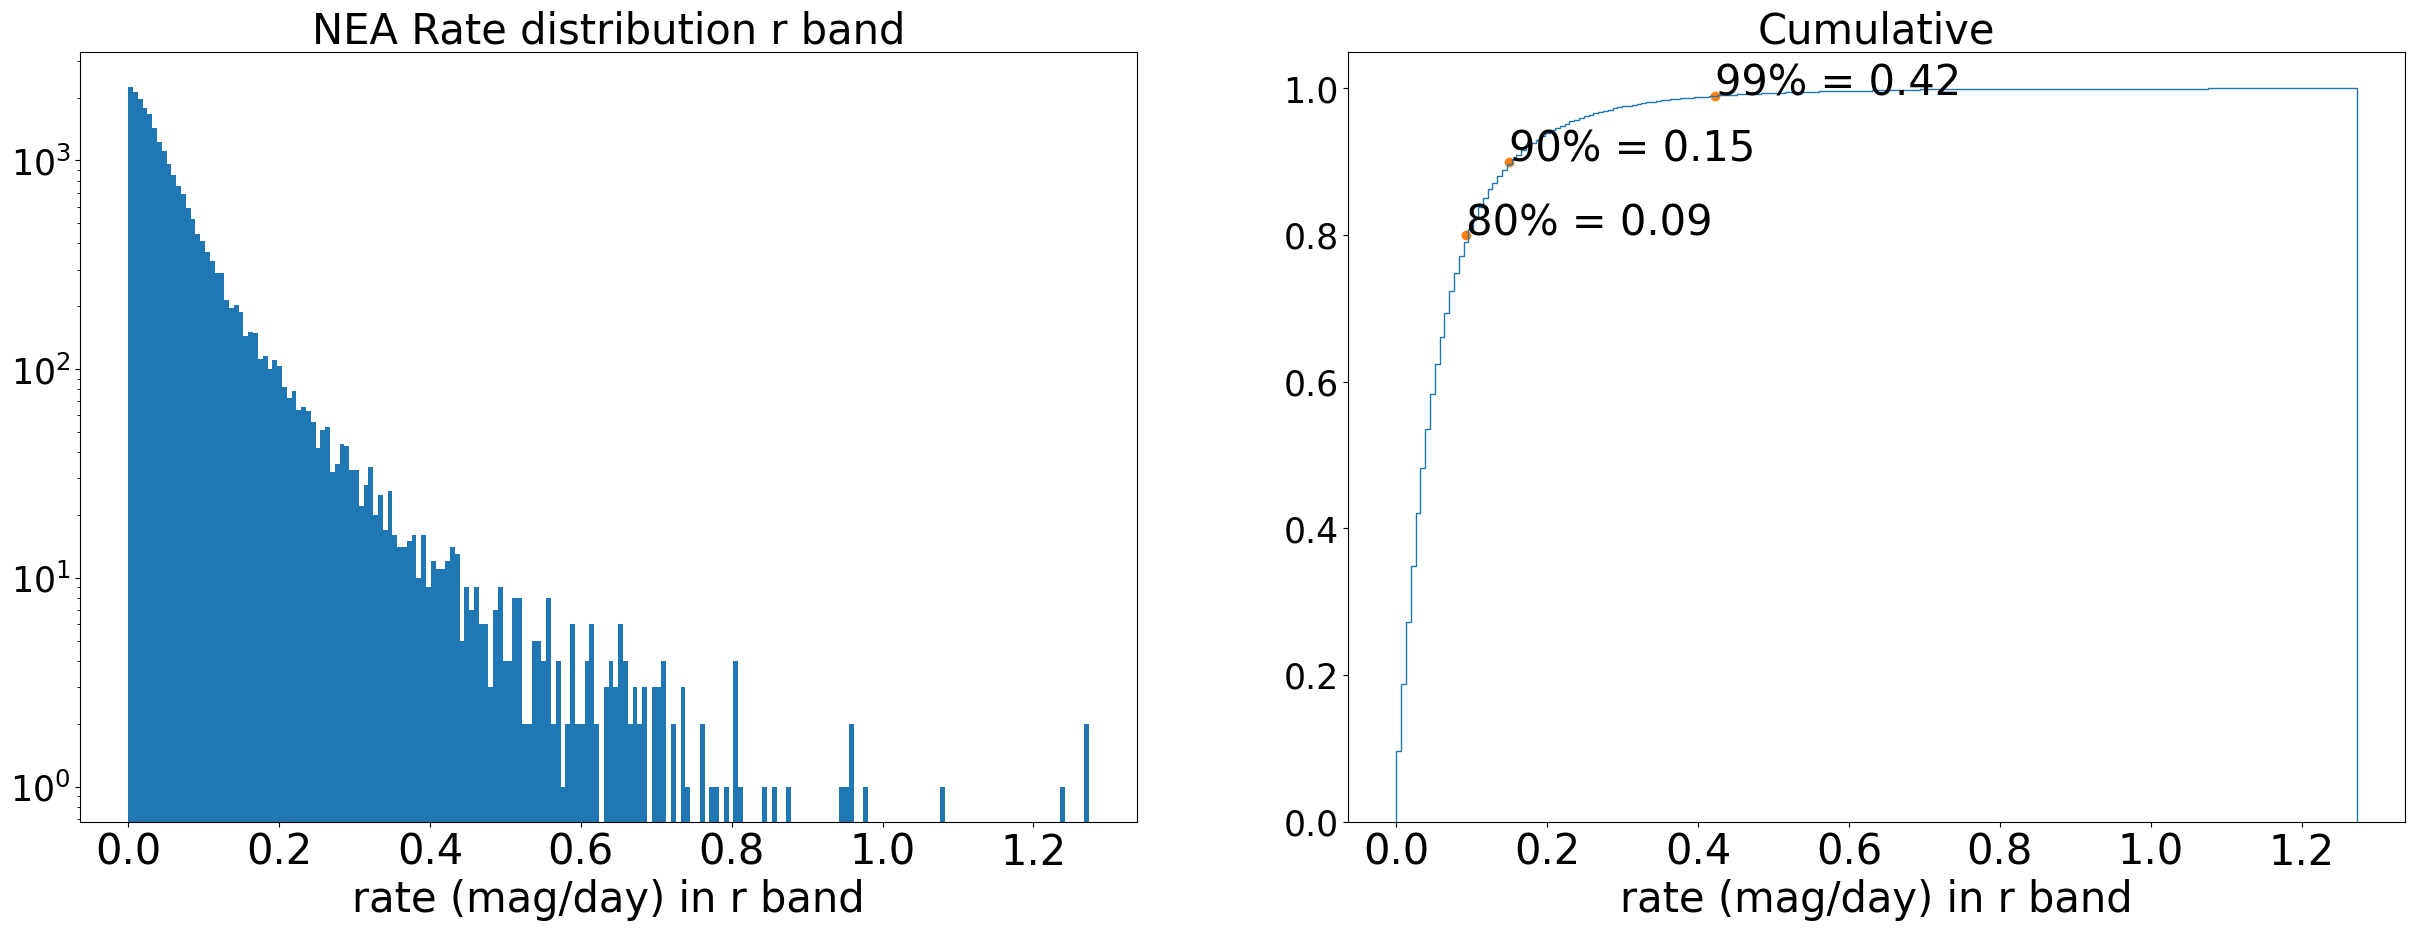

In [15]:
es.plot_hist_and_cdf(
    rate_r, 
    None, 
    "NEA Rate distribution r band", 
    "rate (mag/day) in r band", 
    "", None, 
    "Cumulative", 
    "rate (mag/day) in r band", 
    "", 
    percent_cdf=[0.8, 0.9, 0.99]
)

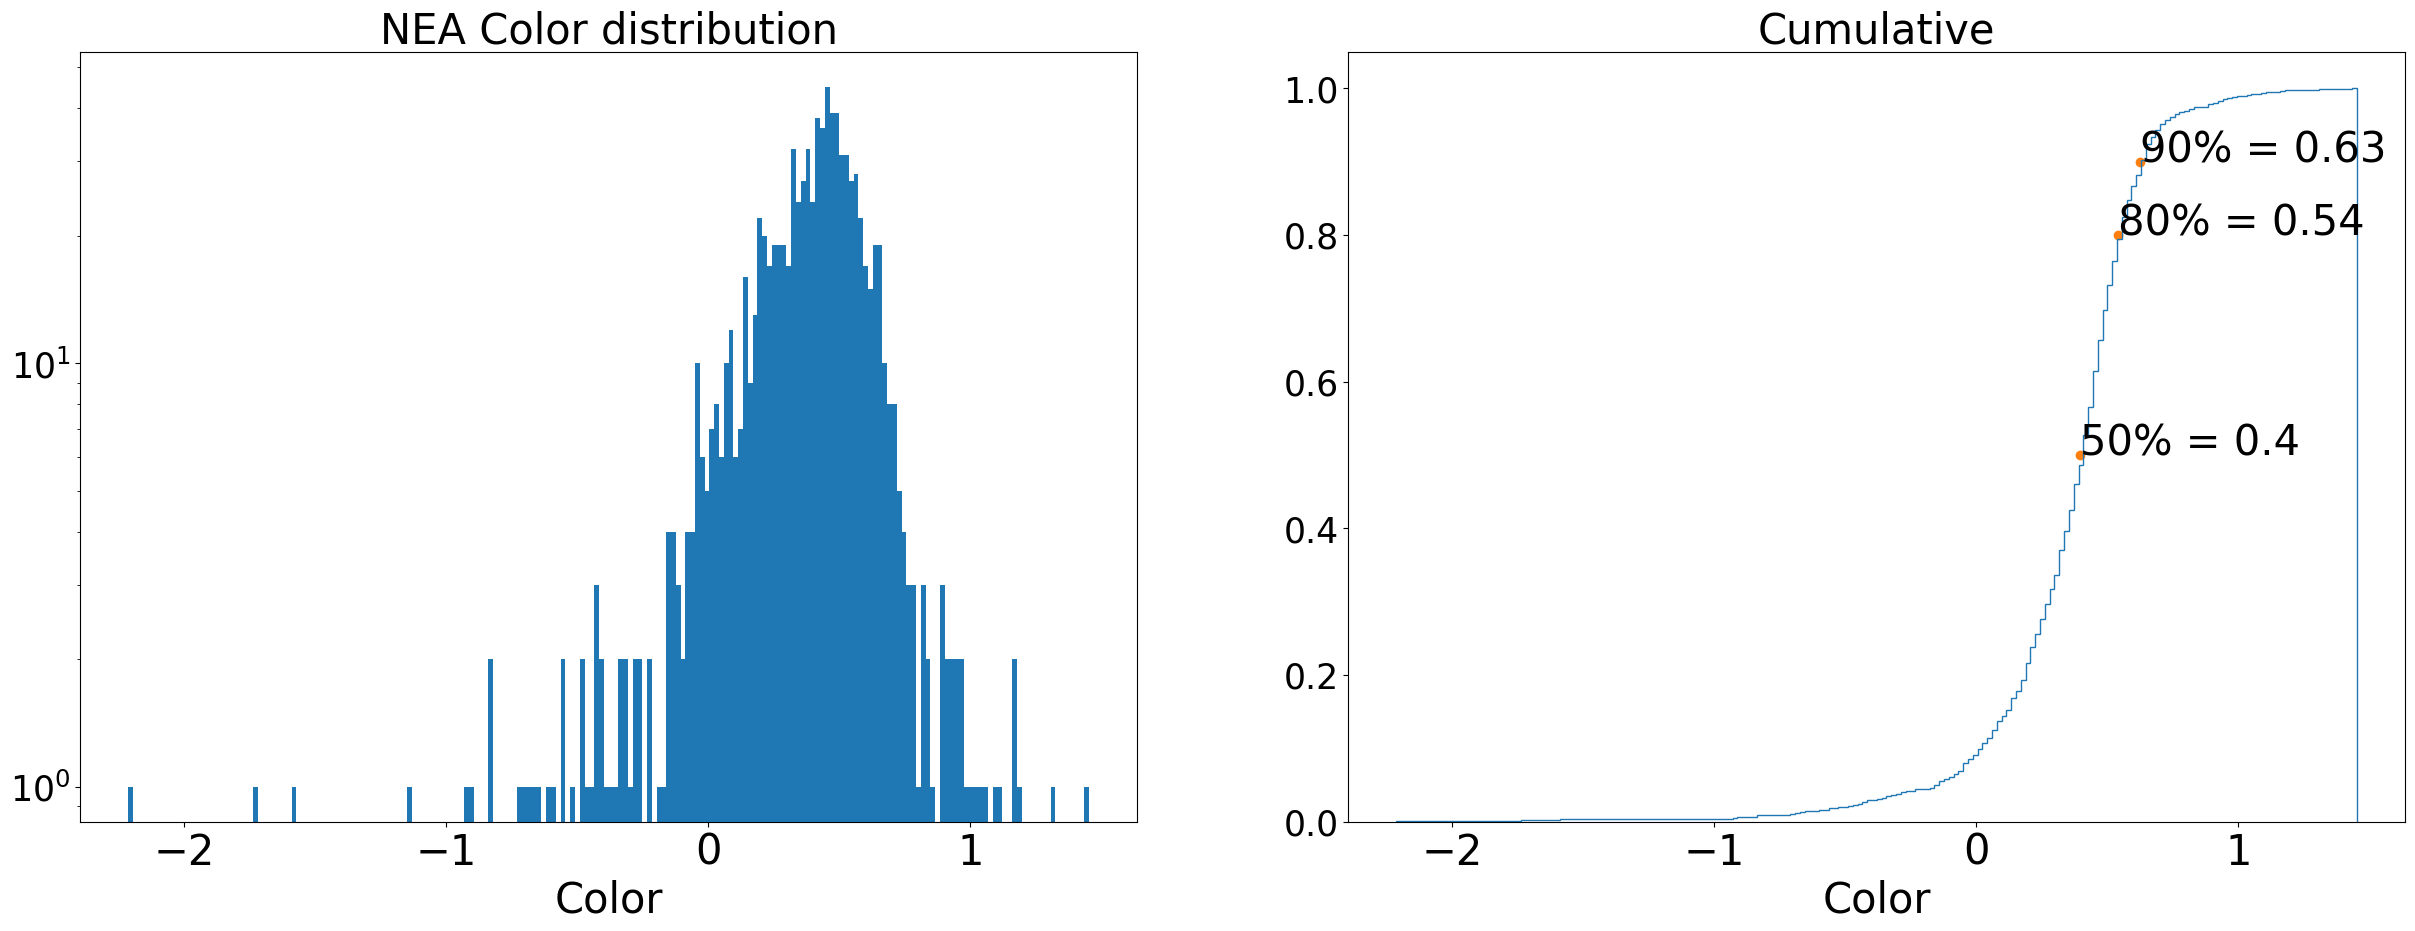

In [16]:
es.plot_hist_and_cdf(
    color,
    None, 
    "NEA Color distribution", 
    "Color", "", 
    None, "Cumulative", 
    "Color", "", 
    percent_cdf=[0.5, 0.8, 0.9]
)

#### Magnitude NEA (Intra only)

In [17]:
prep_intra_rate_gb = nea_fink[["ssnamenr", "nid", "jd", "magpsf", "fid"]].sort_values("jd").groupby(["nid", "ssnamenr"]).agg(
    jd=("jd", list),
    magpsf=("magpsf", list),
    fid=("fid", list),
    nb_obs=("magpsf", len)
)
prep_intra_rate = prep_intra_rate_gb[prep_intra_rate_gb["nb_obs"] > 1]
intra_rate_and_color = prep_intra_rate.reset_index(drop=True).swifter.apply(es.mag_df, axis=1)


intra_rate_g = intra_rate_and_color.explode().reset_index(drop=True)[::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
intra_rate_r = intra_rate_and_color.explode().reset_index(drop=True)[1::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
intra_color = intra_rate_and_color.explode().reset_index(drop=True)[2::3].explode().reset_index(drop=True)
intra_color = intra_color[intra_color != 0]

Pandas Apply:   0%|          | 0/12250 [00:00<?, ?it/s]

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


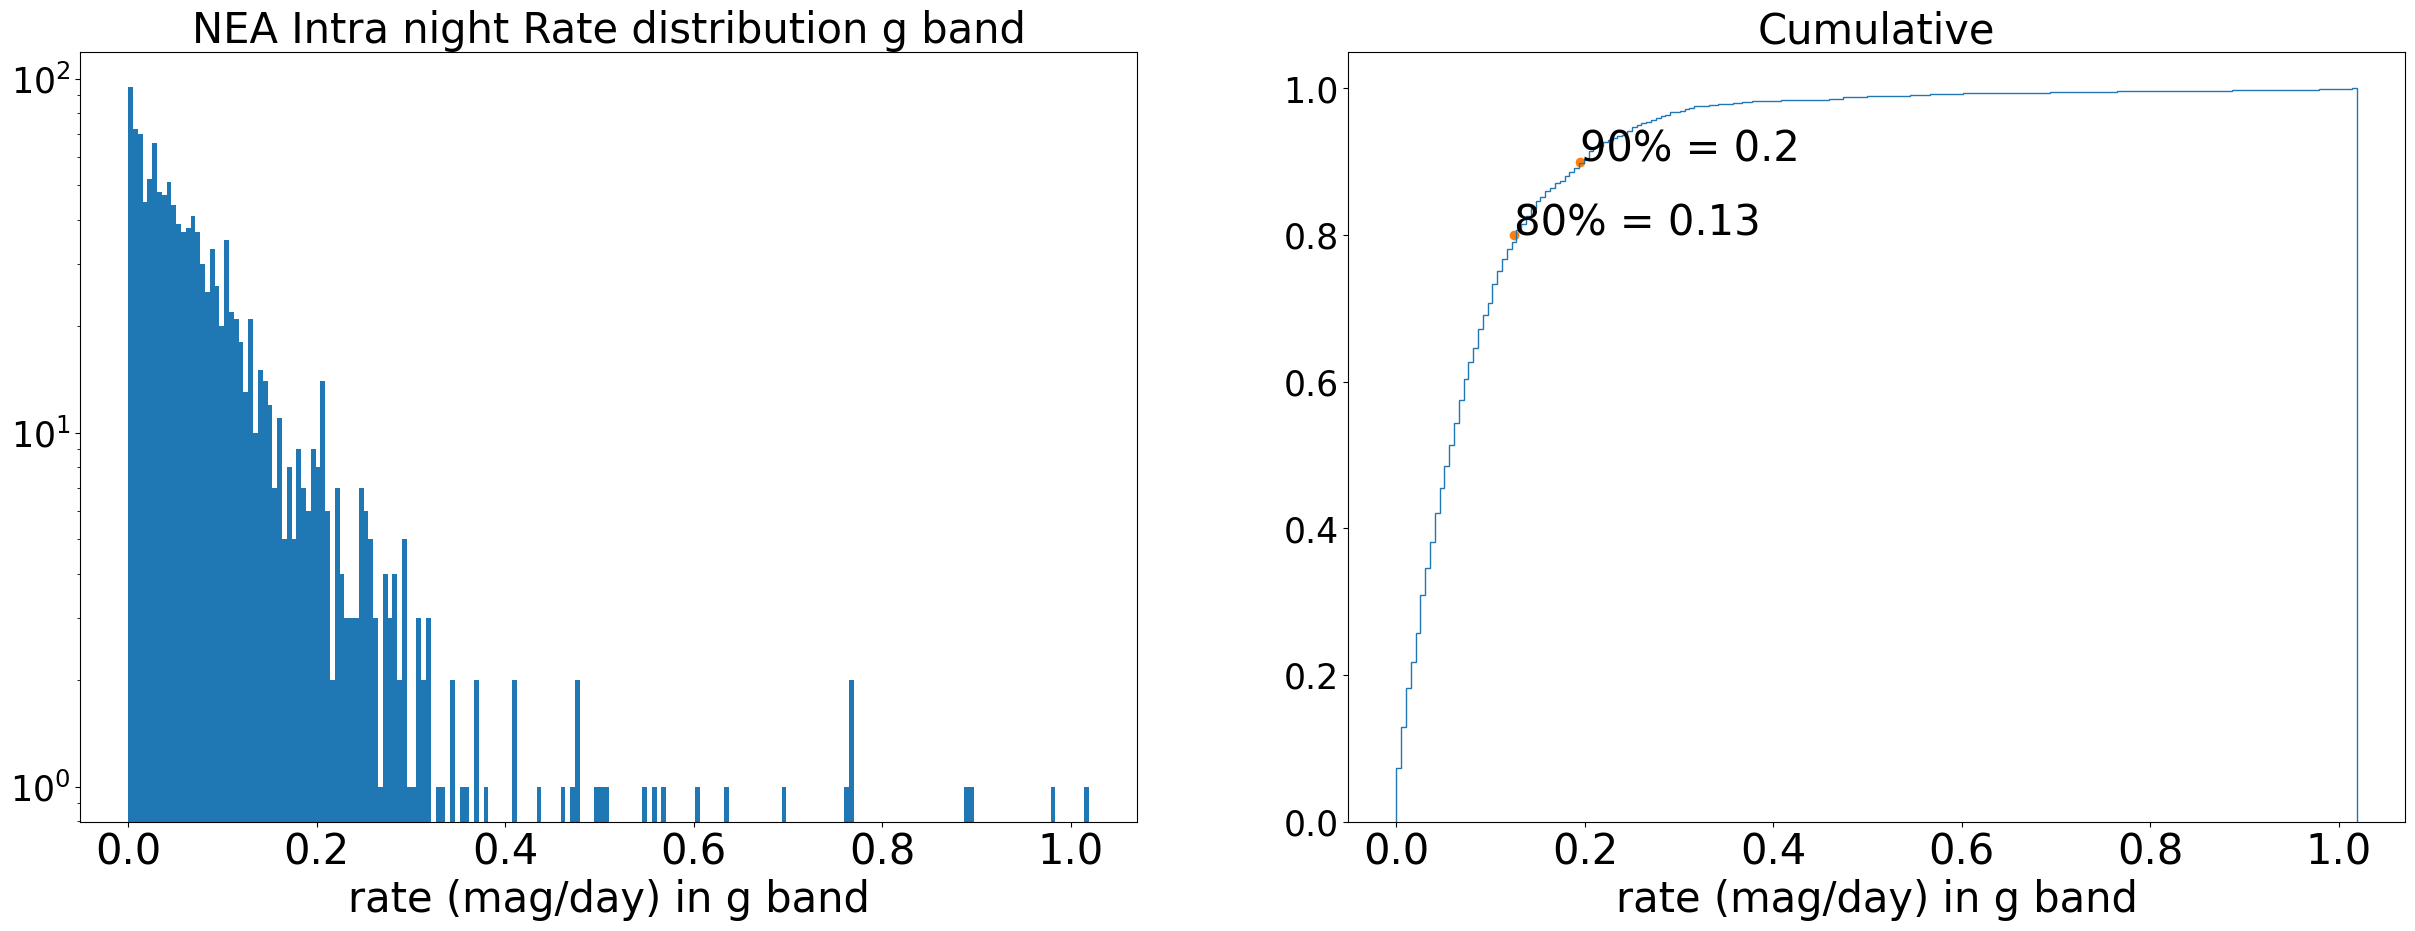

In [18]:
es.plot_hist_and_cdf(
    intra_rate_g, None, 
    "NEA Intra night Rate distribution g band", 
    "rate (mag/day) in g band", "", 
    None, "Cumulative", 
    "rate (mag/day) in g band", ""
)

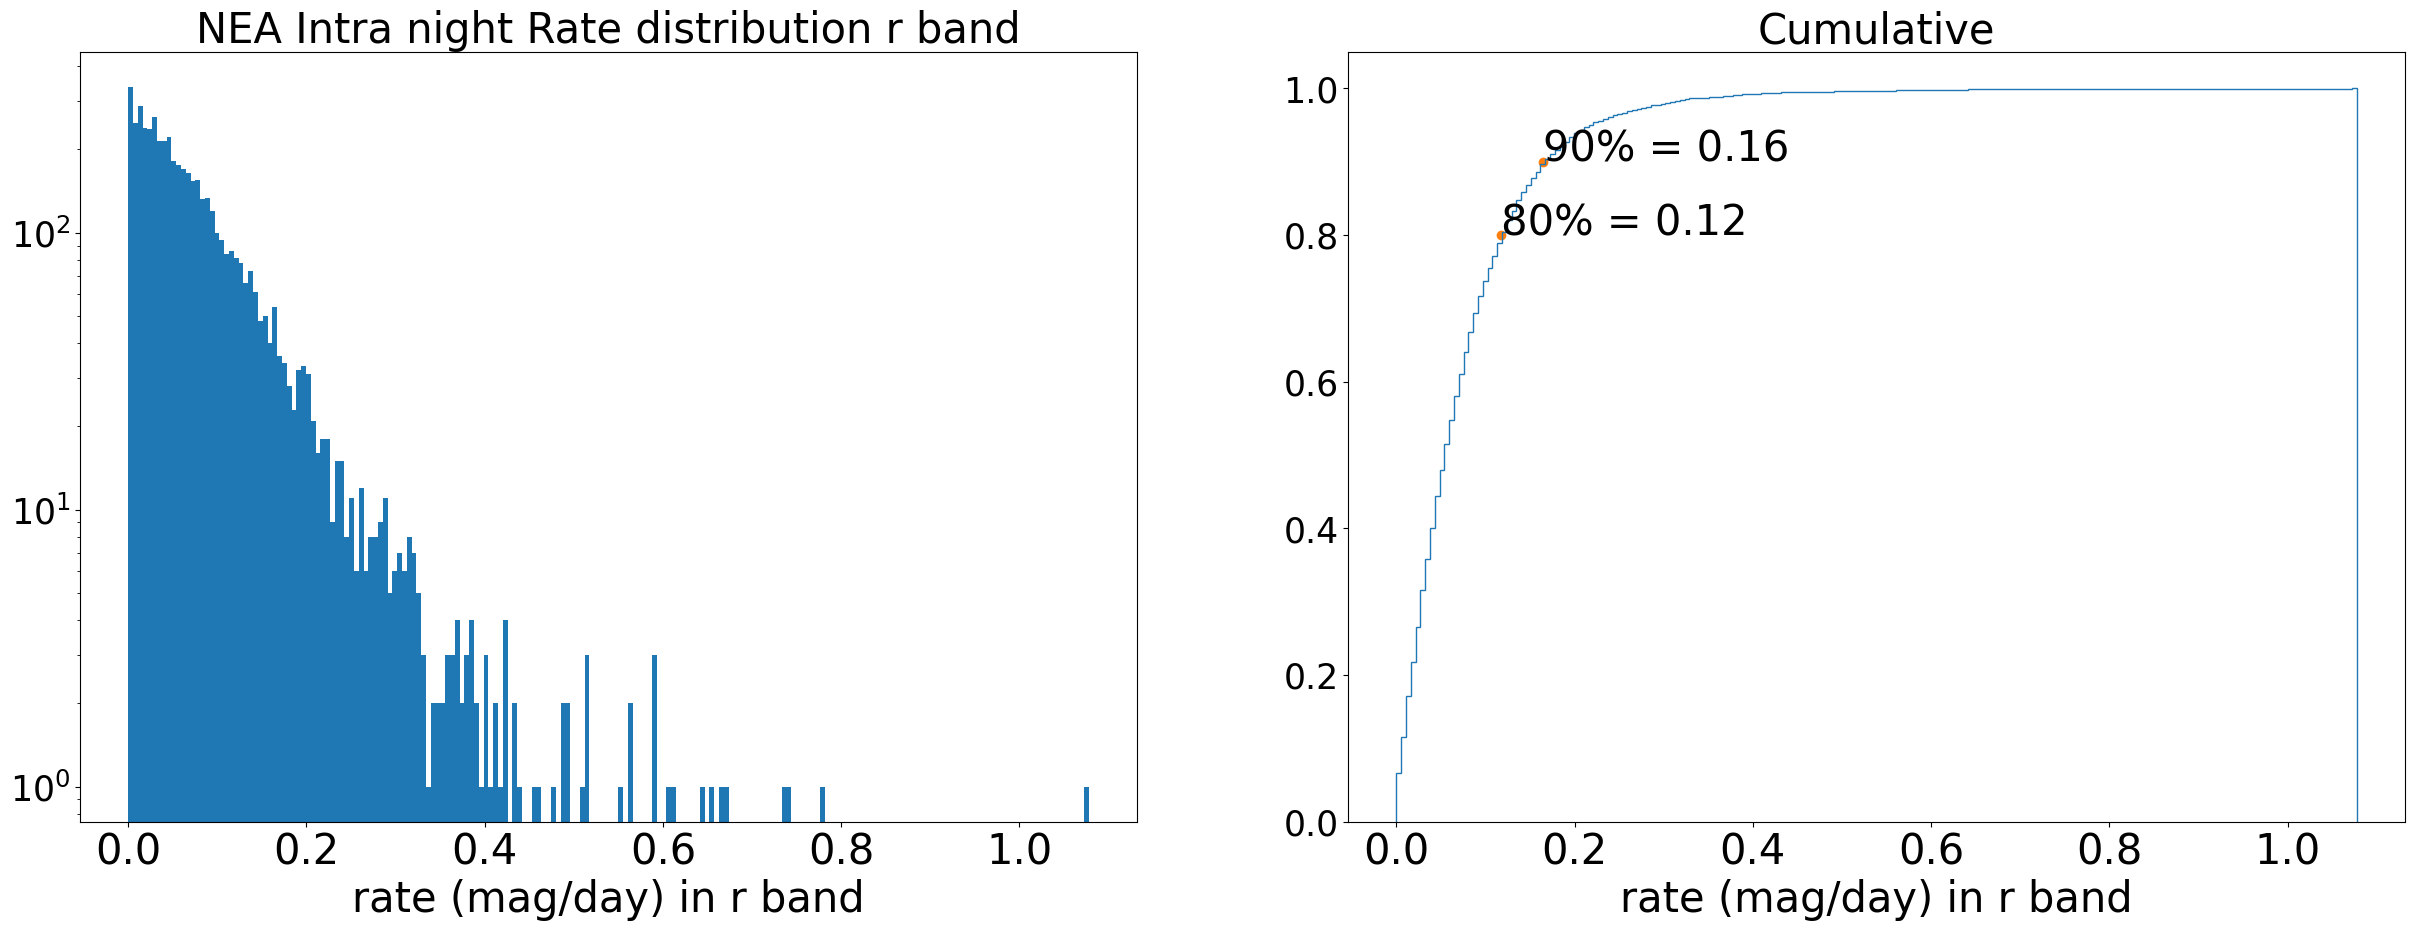

In [19]:
es.plot_hist_and_cdf(
    intra_rate_r, None, 
    "NEA Intra night Rate distribution r band", 
    "rate (mag/day) in r band", "", 
    None, "Cumulative", 
    "rate (mag/day) in r band", ""
)

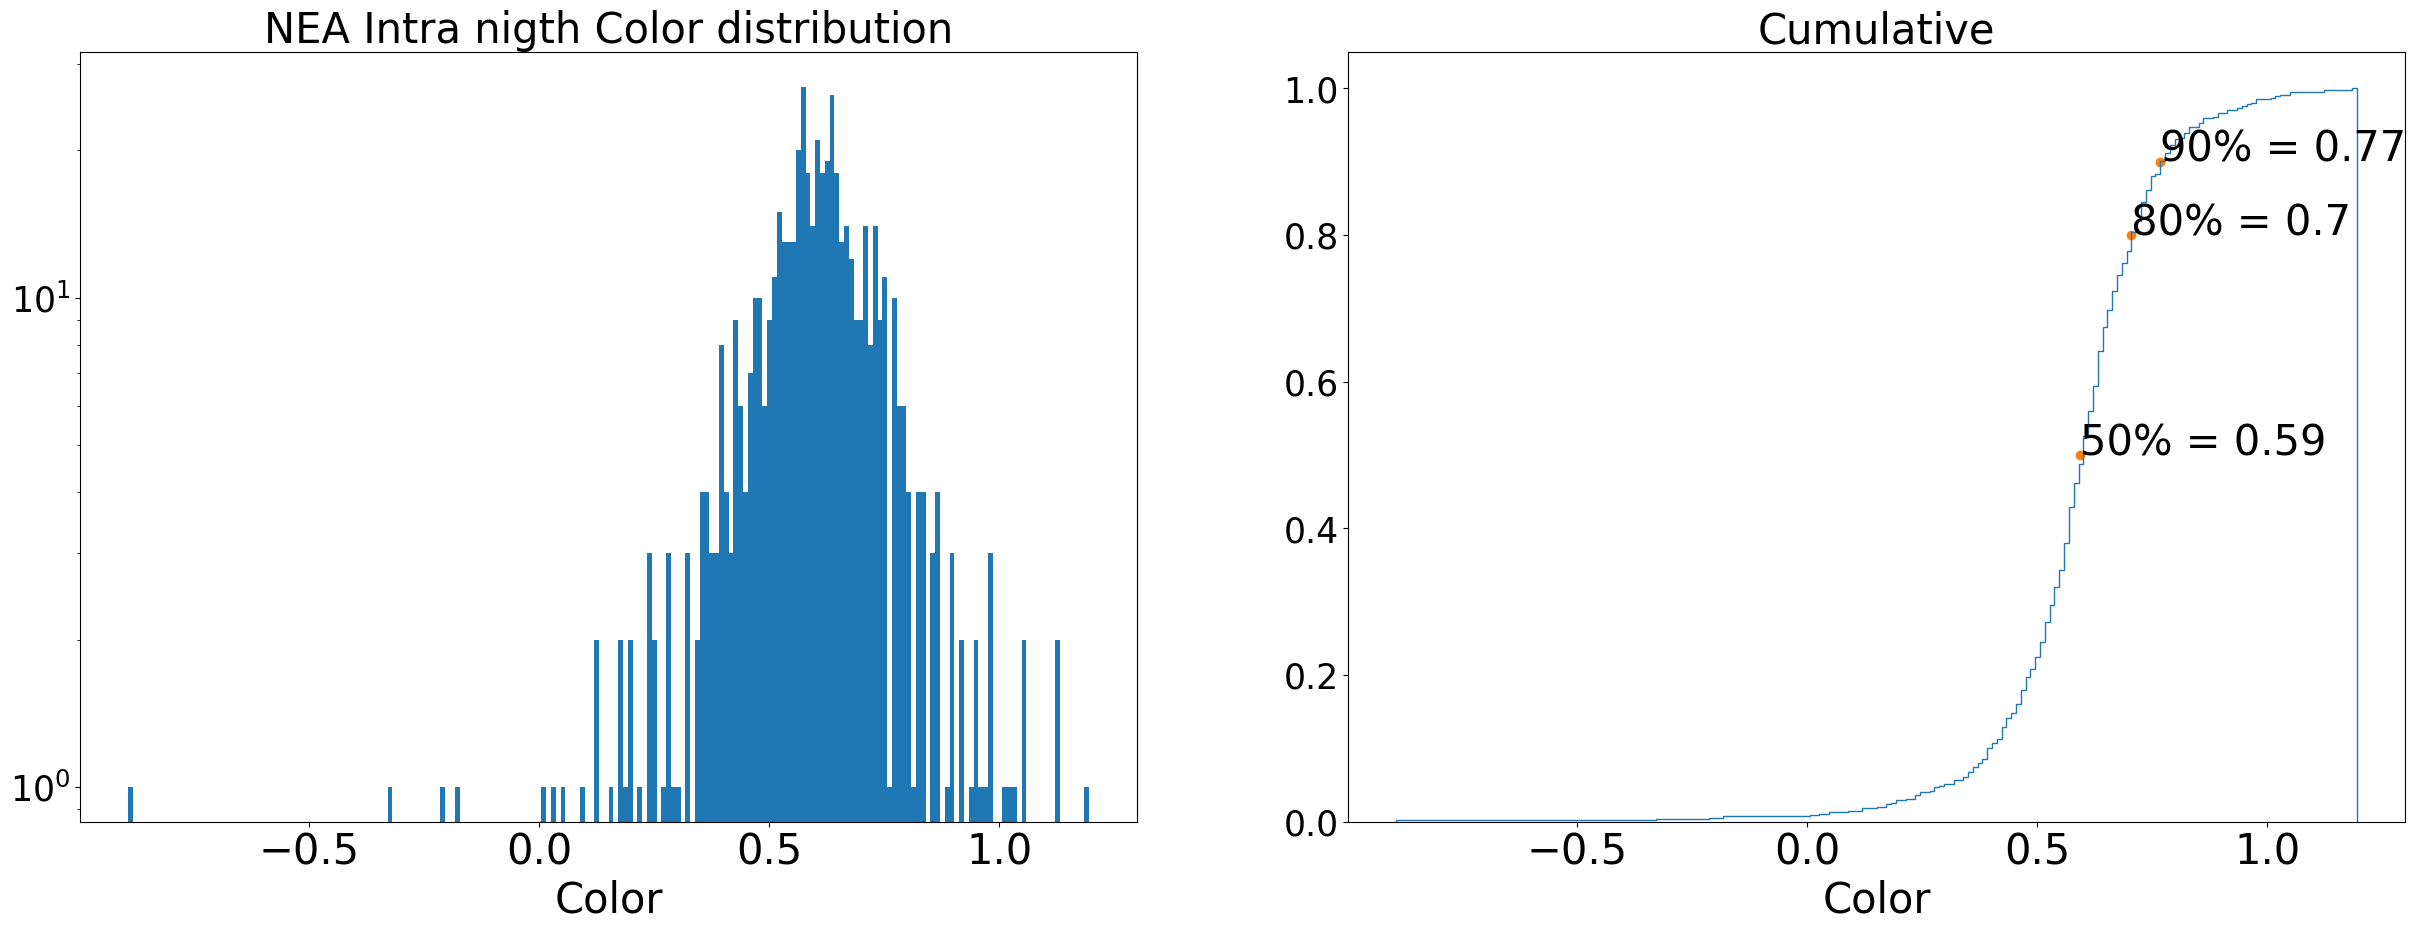

In [20]:
es.plot_hist_and_cdf(
    intra_color, None, 
    "NEA Intra nigth Color distribution", 
    "Color", "", None, 
    "Cumulative", "Color", "", 
    percent_cdf=[0.5, 0.8, 0.9]
)